In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

### importing data

In [47]:
run_qs = RunStats.objects.filter(psearch__id=83, method="BD", status=3)

pd.DataFrame.from_dict(run_qs.values('run_id', 'coherence', 'exclusivity', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter'))

K  alpha  coherence  exclusivity  max_iter  rng_seed  run_id  \
0  45   0.05        NaN          NaN        50         1    2136   
1  45   0.10   0.374046     0.698753        50         1    2118   
2  45   0.01   0.508955     0.742253        50         1    2111   
3  45   0.10   0.491302     0.871996        50         1    2120   
4  45   0.10   0.506084     0.780998        50         1    2121   
5  45   0.05        NaN          NaN        50         1    2137   
6  45   0.05   0.410620     0.806679        50         1    2123   
7  45   0.05   0.370210     0.701541        50         1    2122   
8  45   0.10   0.416262     0.824821        50         1    2119   
9  50   0.01   0.496631     0.781455        50         1    2112   

   top_chain_var  
0          0.010  
1          0.100  
2          0.005  
3          0.010  
4          0.005  
5          0.005  
6          0.050  
7          0.100  
8          0.050  
9          0.005

In [83]:
run_id = 2111
# for ISIE talk: run_id = 1749

save_dir = "./plots/topic_analysis_{}".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

dts = DocTopic.objects.filter(run_id=run_id)
# total score of all DocTopics
print(dts.aggregate(
    n = Sum('score')
))
# total score of DocTopics, sorted by topic
pd.DataFrame.from_dict(list(dts.values('topic__id', 'topic__title').annotate(
    totalscore = Sum('score')
).order_by('-totalscore')))

{'n': 4056676.39996124}


topic__id                                       topic__title  \
0      177264                             {darauf, darub, natur}   
1      177261                         {regier, red, bundeskanzl}   
2      177274                 {wirtschaft, bundesregier, sozial}   
3      177241                {bundesregier, hoh, staatssekretar}   
4      177251                             {milliard, bund, rund}   
5      177250                   {wirtschaft, wachstum, entwickl}   
6      177242                      {europa, gemeinschaft, union}   
7      177269                 {gesetz, wirtschaft, bundesregier}   
8      177244                               {energi, strom, gas}   
9      177249                              {million, tonn, kohl}   
10     177245           {bundesfinanzminist, haushalt, milliard}   
11     177243         {energiepolit, kernenergi, energieversorg}   
12     177273                 {arbeitslos, arbeitsplatz, arbeit}   
13     177265                    {klimaschutz, ziel, coemission}   
14     177259                     {staat, deutsch, bundesrepubl}   
15     177266                     {bergbau, steinkohl, bergleut}   
16     177235                          {million, haushalt, euro}   
17     177260                      {okolog, umweltpolit, umwelt}   
18     177279                   {gesetz, gesetzentwurf, entwurf}   
19     177246                     {deutschland, prozent, merkel}   
20     177278              {kernenergi, kernkraftwerk, ausstieg}   
21     177239                           {deutsch, ausland, volk}   
22     177236                  {forschung, technologi, entwickl}   
23     177263                      {steu, steuerreform, entlast}   
24     177258                {unternehm, mitbestimm, arbeitnehm}   
25     177271        {international, entwicklungsland, weltweit}   
26     177268                    {prozent, deutschland, rotgrun}   
27     177253                            {ost, west, bundesland}   
28     177257                         {bundesbahn, bahn, strass}   
29     177275                  {landwirtschaft, bau, agrarpolit}   
30     177240                    {kilowattstund, energiew, netz}   
31     177277                  {zwischenfrag, deutschland, ziel}   
32     177276                            {dank, grun, kolleginn}   
33     177256                         {region, regional, gebiet}   
34     177254         {wirtschaftspolit, marktwirtschaft, markt}   
35     177248                             {rent, sozial, arbeit}   
36     177272  {nordrheinwestfal, ministerprasident, schleswi...   
37     177262                      {verfahr, gericht, bergrecht}   
38     177238                       {russland, russisch, ukrain}   
39     177270                      {saarland, bundeskanzl, saar}   
40     177267                            {kommun, gemeind, bund}   
41     177247                        {berlin, ddr, bundesrepubl}   
42     177252                     {wohnung, wohnungsbau, sozial}   
43     177255                            {jugend, schul, gesund}   
44     177237                   {kommission, braunkohl, brussel}   

       totalscore  
0   939731.269529  
1   286227.286681  
2   221517.472968  
3   171537.082003  
4   141027.574810  
5   134348.092923  
6   130337.805275  
7   112159.465356  
8   111039.675321  
9   108805.956757  
10  106534.325198  
11   91291.105281  
12   90154.976483  
13   88413.432374  
14   82560.613470  
15   80480.239714  
16   74855.983581  
17   71059.486369  
18   69877.167418  
19   66759.340576  
20   66327.047803  
21   64892.526399  
22   63359.484701  
23   62035.892046  
24   58081.013578  
25   56647.137876  
26   54540.521390  
27   52075.588379  
28   44227.778364  
29   42123.707650  
30   36572.735175  
31   30266.045767  
32   28902.865008  
33   27490.356727  
34   27386.679194  
35   24204.337757  
36   23766.966820  
37   21608.258188  
38   21576.298288  
39   17609.990114  
40   14927.727847  
41   12336.842765  
42   11160.0220

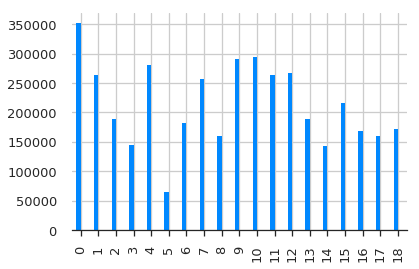

In [49]:
dts_list = list(dts.values('ut__document__parlperiod__n').annotate(
    n = Sum('score')
))
df_dts_list = pd.DataFrame(dts_list)
df_dts_list.columns = ['DocTopic_score', 'parlperiod']
df_dts_list.set_index('parlperiod')
df_dts_list.plot(kind='bar', legend=False)

In [50]:
stat = RunStats.objects.get(run_id=run_id)
search = stat.psearch
uts = pm.Utterance.objects.filter(search_matches=search)
print(uts.count())

period_counts = uts.values('document__parlperiod__n').annotate(n=Count('document__parlperiod__n'))
party_counts = uts.values('speaker__party__name').annotate(n=Count('speaker__party__name'))

9092


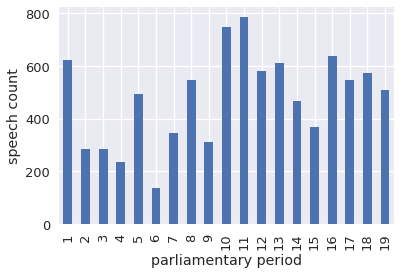

In [51]:
# plot parliamentary period counts
sns.set()
sns.set_context("talk")
df_period_counts = pd.DataFrame.from_dict(period_counts)
df_period_counts = df_period_counts.set_index('document__parlperiod__n')
df_period_counts.plot(kind='bar', legend=False)
plt.xlabel('parliamentary period')
plt.ylabel('speech count')
fig = plt.gcf()
fig.savefig(os.path.join(save_dir, 'parlperiod_speech_count_search_{}.png'.format(search.id)), dpi=300,  bbox_inches="tight")

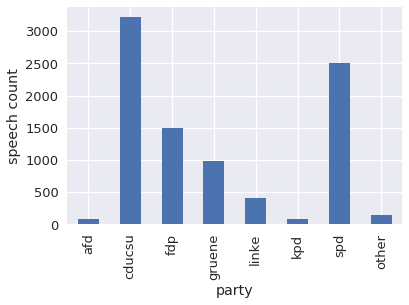

In [72]:
# plot party counts
df_party_counts = pd.DataFrame.from_dict(party_counts)
df_party_counts = df_party_counts.set_index('speaker__party__name')

# drop some of the labels:
#df_party_counts = df_party_counts.drop(["fraktionslos", "parteilos", "pds", None])
# or summarize them:
df_party_counts.loc["other"] = df_party_counts.loc[["bp", "dp", "drp", "dzp", "fraktionslos", "gb/bhe", "other", "parteilos", "pds", "wav", None]].sum()
df_party_counts = df_party_counts.loc[["afd", "cducsu", "fdp", "gruene", "linke", "kpd", "spd", "other"]]

df_party_counts.plot(kind='bar', legend=False)
plt.xlabel('party')
plt.ylabel('speech count')
fig = plt.gcf()
fig.savefig(os.path.join(save_dir, 'party_speech_count_search_{}.png'.format(search.id)), dpi=300,  bbox_inches="tight")

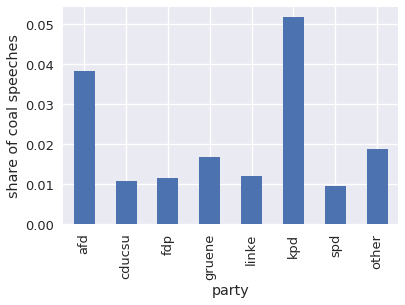

In [82]:
# party shares
party_counts = uts.values('speaker__party__name').annotate(n=Count('speaker__party__name'))
party_counts_all = pm.Utterance.objects.all().values('speaker__party__name').annotate(n_tot=Count('speaker__party__name'))


df_party_counts = pd.DataFrame.from_dict(party_counts)
df_party_counts = df_party_counts.set_index('speaker__party__name')

df_party_counts_all = pd.DataFrame.from_dict(party_counts_all)
df_party_counts_all = df_party_counts_all.set_index('speaker__party__name')

df_pc = df_party_counts.join(df_party_counts_all)

# drop some of the labels:
#df_pc = df_pc.drop(["fraktionslos", "parteilos", "pds", "afd", None])
# or summarize them:
df_pc.loc["other"] = df_pc.loc[["bp", "dp", "drp", "dzp", "fraktionslos", "gb/bhe", "other", "parteilos", "pds", "wav", None]].sum()
df_pc = df_pc.loc[["afd", "cducsu", "fdp", "gruene", "linke", "kpd", "spd", "other"]]

df_pc['share'] = df_pc['n'] / df_pc['n_tot']

df_pc.plot(kind='bar', y="share", legend=False)
plt.xlabel('party')
plt.ylabel('share of coal speeches')
fig = plt.gcf()
fig.savefig(os.path.join(save_dir,'party_share_search_{}.png'.format(search.id)), dpi=300,  bbox_inches="tight")

---

### Overall DocTopic score - Time plot

**test topics**: steinkohl, umweltschutz, international, forschung, saar 

In [84]:
dts.values('topic__title','ut__document__parlperiod__n').annotate(n = Sum('score'))

<QuerySet [{'topic__title': '{arbeitslos, arbeitsplatz, arbeit}', 'ut__document__parlperiod__n': 1, 'n': 1824.15788078426}, {'topic__title': '{arbeitslos, arbeitsplatz, arbeit}', 'ut__document__parlperiod__n': 2, 'n': 468.99750984542}, {'topic__title': '{arbeitslos, arbeitsplatz, arbeit}', 'ut__document__parlperiod__n': 3, 'n': 932.81719696374}, {'topic__title': '{arbeitslos, arbeitsplatz, arbeit}', 'ut__document__parlperiod__n': 4, 'n': 185.444491877321}, {'topic__title': '{arbeitslos, arbeitsplatz, arbeit}', 'ut__document__parlperiod__n': 5, 'n': 1194.69430444431}, {'topic__title': '{arbeitslos, arbeitsplatz, arbeit}', 'ut__document__parlperiod__n': 6, 'n': 311.839043025731}, {'topic__title': '{arbeitslos, arbeitsplatz, arbeit}', 'ut__document__parlperiod__n': 7, 'n': 979.677028555892}, {'topic__title': '{arbeitslos, arbeitsplatz, arbeit}', 'ut__document__parlperiod__n': 8, 'n': 3236.44896690646}, {'topic__title': '{arbeitslos, arbeitsplatz, arbeit}', 'ut__document__parlperiod__n': 9

In [86]:
topic_period_scores = dts.values('topic__title','ut__document__parlperiod__n').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'parlperiod']
df_scores = df.pivot(index='parlperiod', columns='topic', values='score')
df_scores

topic       {arbeitslos, arbeitsplatz, arbeit}  \
parlperiod                                       
1                                  1824.157881   
2                                   468.997510   
3                                   932.817197   
4                                   185.444492   
5                                  1194.694304   
6                                   311.839043   
7                                   979.677029   
8                                  3236.448967   
9                                  4668.263522   
10                                14968.888984   
11                                13165.920140   
12                                14263.132174   
13                                14581.844365   
14                                 5691.646061   
15                                 4403.336677   
16                                 3228.867579   
17                                 2468.707696   
18                                 2150.646068   
19                                 1429.646795   

topic       {bergbau, steinkohl, bergleut}  {berlin, ddr, bundesrepubl}  \
parlperiod                                                                
1                               606.920174                  1468.140400   
2                               762.237146                   397.763815   
3                              1324.888877                   149.631573   
4                              2367.523997                   216.704089   
5                              5370.101627                   293.752907   
6                               359.586249                   101.151267   
7                              1770.569979                   214.112747   
8                              2557.895711                   586.988567   
9                              2783.871093                  1183.274494   
10                             8079.622524                   791.997003   
11                            24502.292932                  4049.121025   
12                            14297.498039                   998.155234   
13                             4783.335774                   655.740097   
14                             1299.057348                   487.110933   
15                             2396.303803                   113.918838   
16                             3358.885379                   127.115146   
17                             2815.194114                   135.056563   
18                              684.966564                   253.324428   
19                              359.488381                   113.783639   

topic       {bundesbahn, bahn, strass}  \
parlperiod                               
1                          4725.374713   
2                         16825.304448   
3                          5073.243075   
4                          3101.143192   
5                          4387.380004   
6                           497.855073   
7                           803.415556   
8                           716.421193   
9                           399.903183   
10                         1862.108374   
11                          705.175431   
12                         1347.522348   
13                          864.894690   
14                          723.988347   
15                          253.055747   
16                          600.876257   
17                          593.677207   
18                          348.588659   
19                          397.850868   

topic       {bundesfinanzminist, haushalt, milliard}  \
parlperiod                                             
1                                         499.912971   
2                                         699.733541   
3                                         812.474667   
4                                         398.012498   
5                                        1629.112403   
6                                        1227.665989   
7                                        4

In [87]:
# normalization
df_shares = df_scores.copy()
for i in df_shares.index:
    df_shares.loc[i] = df_scores.loc[i] / df_scores.loc[i].sum() * 100
df_shares

topic       {arbeitslos, arbeitsplatz, arbeit}  \
parlperiod                                       
1                                     0.517787   
2                                     0.178291   
3                                     0.492263   
4                                     0.128910   
5                                     0.425125   
6                                     0.485503   
7                                     0.536841   
8                                     1.257373   
9                                     2.931820   
10                                    5.151524   
11                                    4.470909   
12                                    5.410706   
13                                    5.472534   
14                                    3.023937   
15                                    3.075857   
16                                    1.496764   
17                                    1.459430   
18                                    1.343849   
19                                    0.830232   

topic       {bergbau, steinkohl, bergleut}  {berlin, ddr, bundesrepubl}  \
parlperiod                                                                
1                                 0.172274                     0.416732   
2                                 0.289766                     0.151211   
3                                 0.699166                     0.078963   
4                                 1.645763                     0.150640   
5                                 1.910920                     0.104530   
6                                 0.559841                     0.157483   
7                                 0.970233                     0.117329   
8                                 0.993752                     0.228047   
9                                 1.748361                     0.743135   
10                                2.780592                     0.272565   
11                                8.320537                     1.375009   
12                                5.423743                     0.378649   
13                                1.795175                     0.246098   
14                                0.690181                     0.258799   
15                                1.673887                     0.079576   
16                                1.557035                     0.058925   
17                                1.664263                     0.079842   
18                                0.428007                     0.158292   
19                                0.208764                     0.066077   

topic       {bundesbahn, bahn, strass}  \
parlperiod                               
1                             1.341297   
2                             6.396181   
3                             2.677234   
4                             2.155731   
5                             1.561224   
6                             0.775112   
7                             0.440254   
8                             0.278332   
9                             0.251152   
10                            0.640842   
11                            0.239465   
12                            0.511181   
13                            0.324593   
14                            0.384651   
15                            0.176767   
16                            0.278540   
17                            0.350965   
18                            0.217818   
19                            0.231042   

topic       {bundesfinanzminist, haushalt, milliard}  \
parlperiod                                             
1                                           0.141900   
2                                           0.266005   
3                                           0.428756   
4                                           0.276675   
5                                           0.579710   
6                                           1.911356   
7                                         

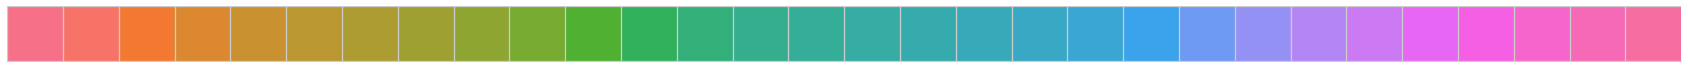

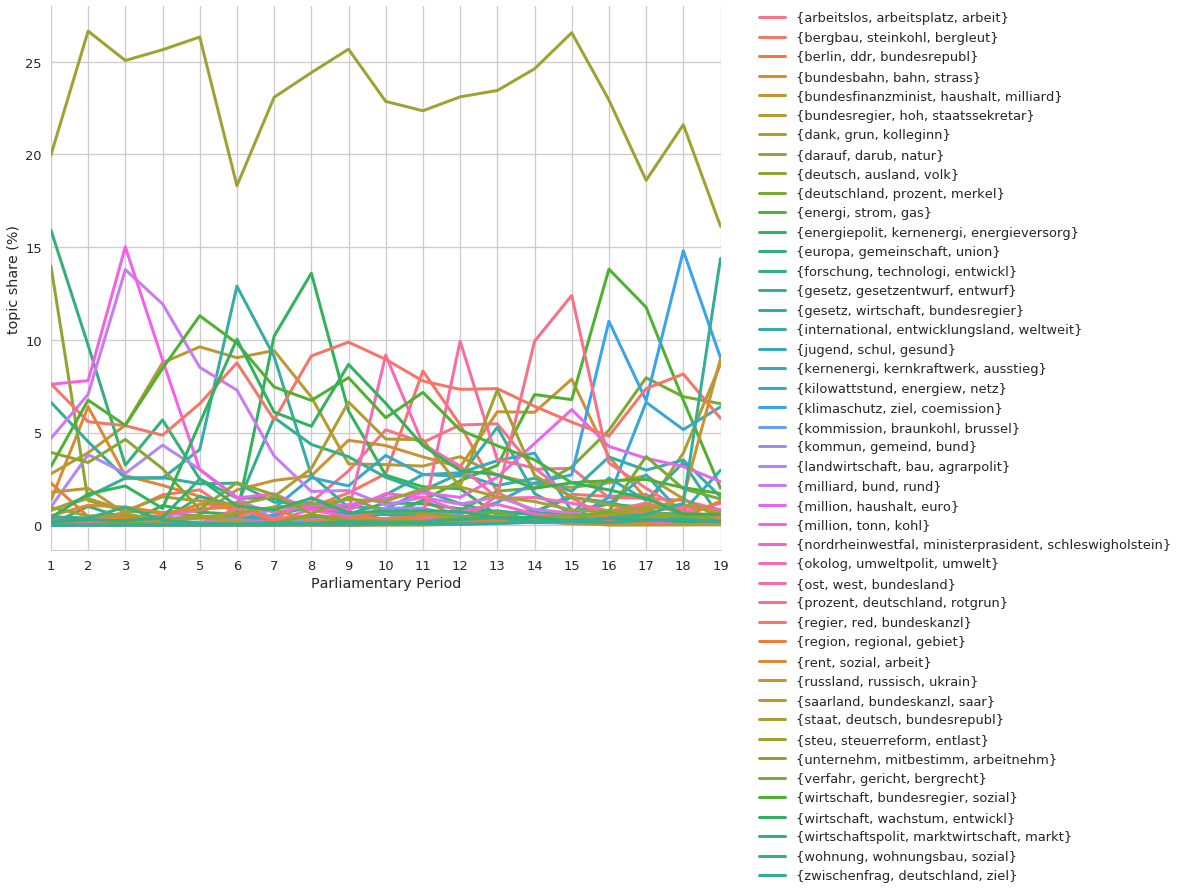

In [88]:
%matplotlib inline
# figure aesthetics
sns.set_style('whitegrid')
plt.rcParams['lines.linewidth'] = 3

sns.set_palette('husl', 30)
#sns.set_palette('muted')
sns.palplot(sns.color_palette())

ax = df_shares.plot(figsize=(12,10), xticks = df_shares.index)
ax.set(xlabel='Parliamentary Period', ylabel='topic share (%)')

fig = plt.gcf()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# fig.savefig('dtopicscore_topic_comparison.png')

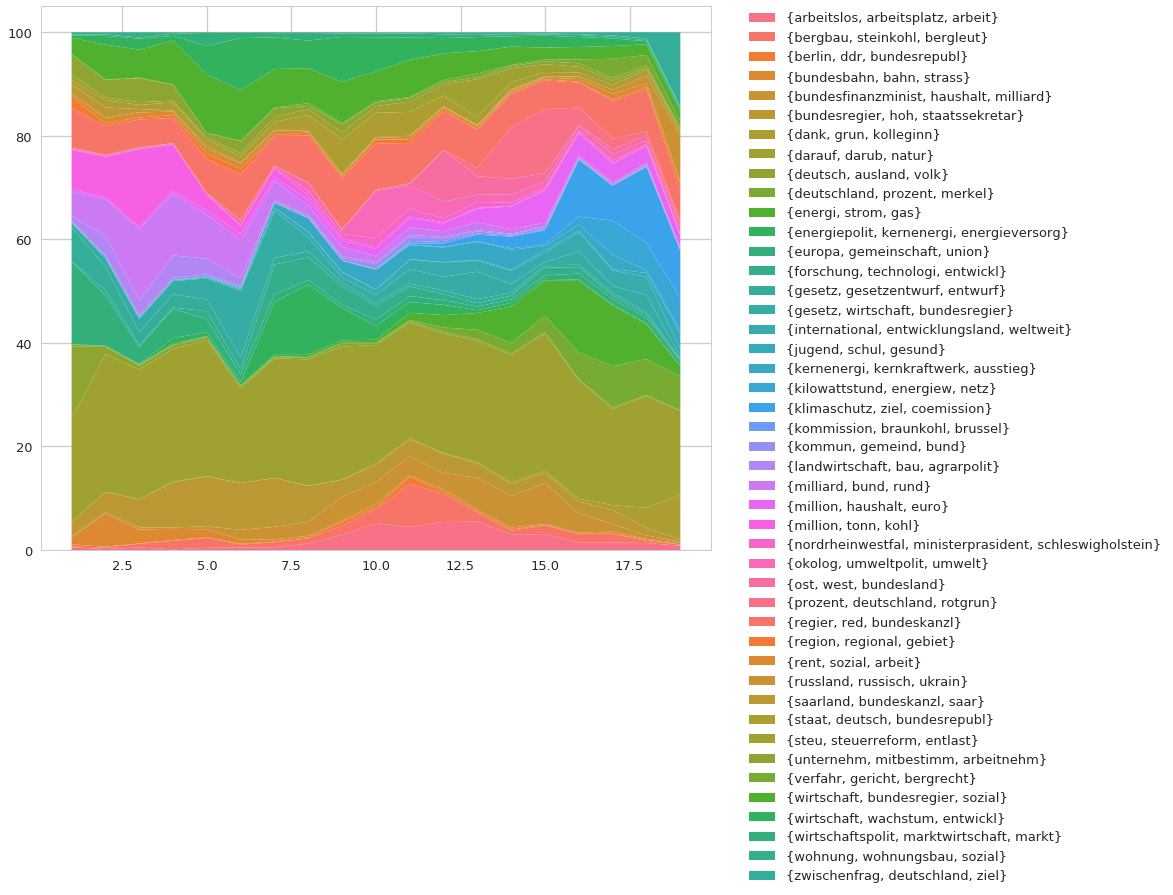

In [20]:
fig = plt.figure(figsize=(12,10))
plt.stackplot(df_shares.index, df_shares.T, labels=df_shares.columns)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

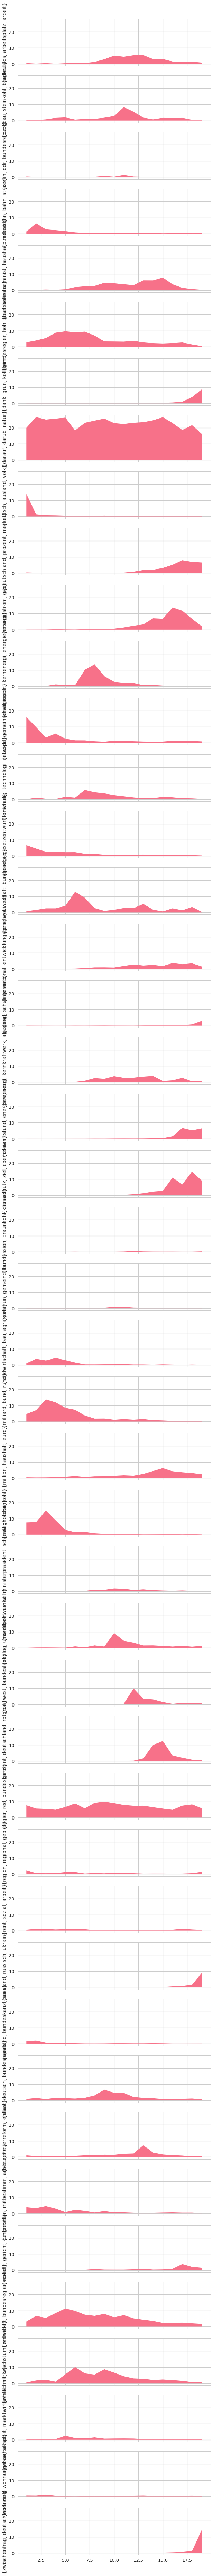

In [21]:
#dfs = df[["EU", "finance"]]
dfs = df_shares
#print(dfs)

fig, ax = plt.subplots(len(dfs.columns), 1, figsize=(10, len(dfs.columns)*3), sharex=True, sharey=True)

for i, t in enumerate(dfs.columns):
    ax[i].stackplot(dfs.index, dfs[t])
    ax[i].set_ylabel(t)

#fig.save('')

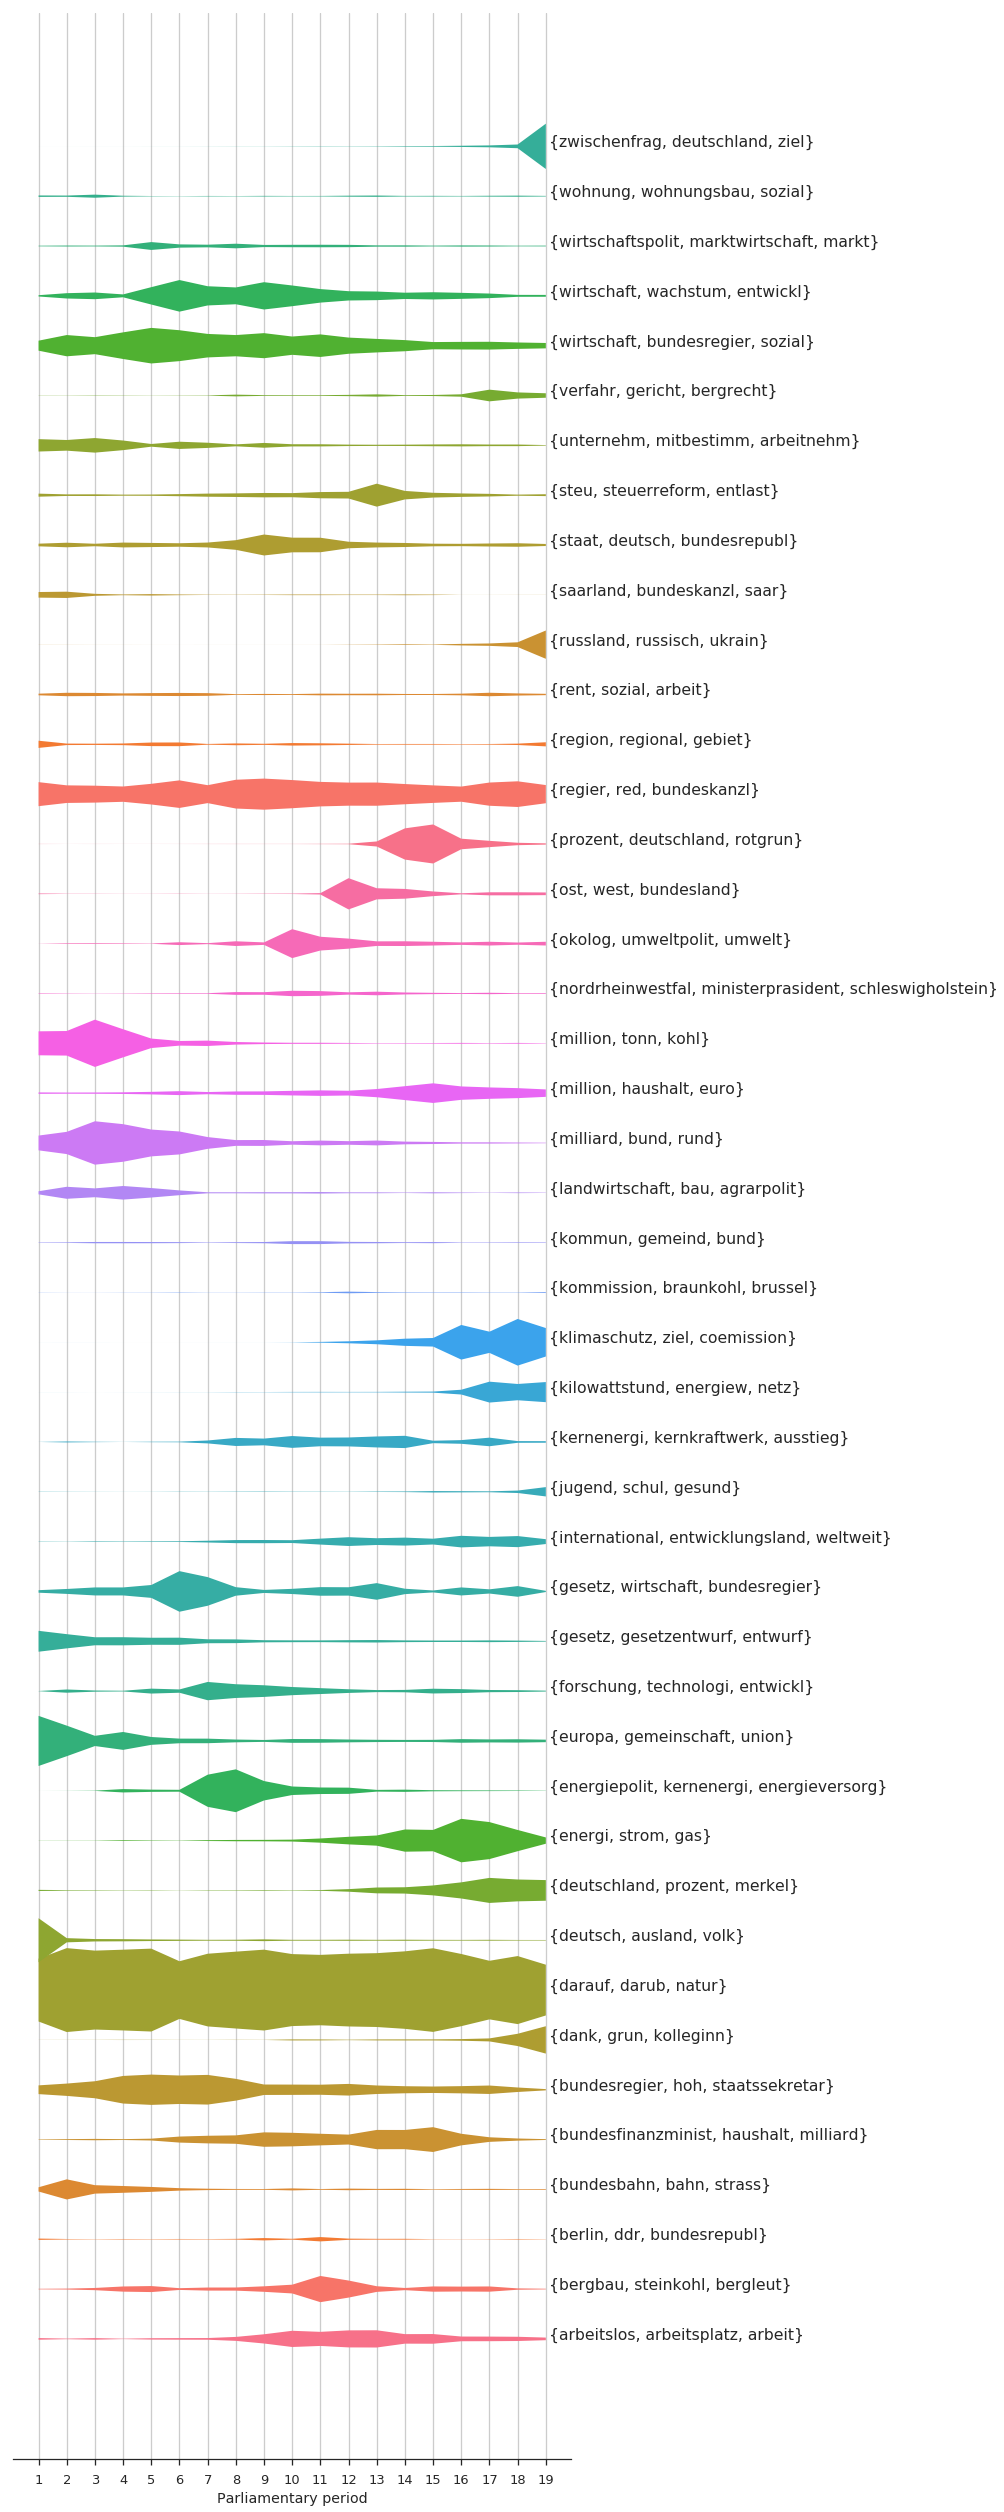

In [89]:
#dfs = df[["EU", "finance"]]
#dfs = df_shares[["hard coal mining",  "EU", "energy transition 3", "energy transition 2", "energy transition",
#          "economy & jobs", "east germany", "development", "climate protection", "climate policy"]]
#print(dfs)
dfs = df_shares

sns.set_context("talk")
sns.set_style("ticks")
sns.set_style({'axes.spines.bottom': True,
               'axes.grid':True,
               'axes.spines.left': False,
               'axes.spines.right': False,
               'axes.spines.top': False,
               'ytick.left': False})


fig = plt.figure(figsize=(10, len(dfs.columns)))
max_val = dfs.max().max() + 5

for i, t in enumerate(dfs.columns):
    plt.fill_between(dfs.index, dfs[t] + i*max_val, i*max_val - dfs[t], label=t)
    plt.text(19.1, (i+0.) *max_val, t)

ax = fig.gca()
plt.yticks([])
plt.xticks(range(1,20))

plt.xlabel('Parliamentary period')
plt.savefig(os.path.join(save_dir, 'topic_selection_run{}.png'.format(run_id)), dpi=300, bbox_inches="tight")


---

### Party Analysis

In [105]:
topic_id = 177242
topic_label = Topic.objects.get(id=topic_id).title
t1_party_totals = pm.Utterance.objects.filter(
    doctopic__topic__run_id=run_id, 
    speaker__party__name__isnull=False,
    speaker__party__colour__isnull=False
).order_by().values('speaker__party__name','document__parlperiod__n').annotate(
    topic_score=Sum(
        Case(
            When(doctopic__topic=topic_id,
                 then=F('doctopic__score')),
            default=0,
            output_field=models.FloatField()
        )),
    total_score=Sum('doctopic__score'),
).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
    'document__parlperiod__n', #parlperiod
    'topic_score', #doctopicscore
    'total_score',
    'topic_proportion',
    'speaker__party__id',
    'speaker__party__name',
    'speaker__party__colour'
).order_by('-document__parlperiod__n')

dft = pd.DataFrame.from_dict(list(t1_party_totals))
dft

document__parlperiod__n speaker__party__colour  speaker__party__id  \
0                        19                #009EE0                 112   
1                        19                #000000                 107   
2                        19                #FFED00                 109   
3                        19                #64A12D                 111   
4                        19                #8C3473                 108   
5                        19                #EB001F                 110   
6                        18                #000000                 107   
7                        18                #64A12D                 111   
8                        18                #8C3473                 108   
9                        18                #EB001F                 110   
10                       17                #000000                 107   
11                       17                #FFED00                 109   
12                       17                #64A12D                 111   
13                       17                #8C3473                 108   
14                       17                #EB001F                 110   
15                       16                #000000                 107   
16                       16                #FFED00                 109   
17                       16                #64A12D                 111   
18                       16                #8C3473                 108   
19                       16                #EB001F                 110   
20                       15                #000000                 107   
21                       15                #FFED00                 109   
22                       15                #64A12D                 111   
23                       15                #8C3473                 108   
24                       15                #EB001F                 110   
25                       14                #000000                 107   
26                       14                #FFED00                 109   
27                       14                #64A12D                 111   
28                       14                #8C3473                 108   
29                       14                #EB001F                 110   
..                      ...                    ...                 ...   
48                       10                #8C3473                 108   
49                       10                #EB001F                 110   
50                        9                #000000                 107   
51                        9                #FFED00                 109   
52                        9                #8C3473                 108   
53                        9                #EB001F                 110   
54                        8                #000000                 107   
55                        8                #FFED00                 109   
56                        8                #EB001F                 110   
57                        7                #000000                 107   
58                        7                #FFED00                 109   
59                        7                #EB001F                 110   
60                        6                #000000                 107   
61                        6                #FFED00                 109   
62                        6                #EB001F                 110   
63                        5                #000000                 107   
64                        5                #FFED00                 109   
65                        5                #EB001F                 110   
66                        4                #000000                 107   
67                        4                #FFED00                 109   
68                        4                #EB001F                 110   
69                        3                #000000                 107   
70      

In [84]:
# from parliament/views.py

# note: speaker__party__colour__isnull=False prevents loading data for other parties

def get_table_for_party_plots(topic_id):
    
    topic_label = Topic.objects.get(id=topic_id).title
    t1_party_totals = pm.Utterance.objects.filter(
        doctopic__topic__run_id=run_id, 
        speaker__party__name__isnull=False,
        speaker__party__colour__isnull=False
    ).order_by().values('speaker__party__name','document__parlperiod__n').annotate(
        topic_score=Sum(
            Case(
                When(doctopic__topic=topic_id,
                     then=F('doctopic__score')),
                default=0,
                output_field=models.FloatField()
            )),
        total_score=Sum('doctopic__score'),
    ).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
        'document__parlperiod__n', #parlperiod
        'topic_score', #doctopicscore
        'total_score',
        'topic_proportion',
        'speaker__party__id',
        'speaker__party__name',
        'speaker__party__colour'
    ).order_by('-document__parlperiod__n')
    
    dft = pd.DataFrame.from_dict(list(t1_party_totals))
    dft.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
    dft_score = pd.DataFrame([dft['parlperiod'], dft['party_name'], dft['doctopic_score']]).transpose()
    dft_score = dft_score.pivot(index='parlperiod', columns='party_name', values='doctopic_score')
    
    dft_proportion = pd.DataFrame([dft['parlperiod'], dft['party_name'], dft['doctopic_proportion']]).transpose()
    dft_proportion = dft_proportion.pivot(index='parlperiod', columns='party_name', values='doctopic_proportion')
    
    return dft_score, dft_proportion

In [85]:
# Stacked bar plot scores
def stacked_bar_plot_party(df, topic_label, filename="", pct=False, value_name="DocTopic score"):
    
    if pct:
        df_plot = df.copy()
        for i in df_plot.index:
            df_plot.loc[i] = df_plot.loc[i] / df_plot.loc[i].sum() * 100
        ylabel = '% of {}'.format(value_name)
        title_str = "Percentage of {} per party for '{}'".format(value_name, topic_label)
    
    else:
        ylabel = value_name
        title_str = "{} per party for '{}'".format(value_name, topic_label)
        df_plot = df
        
    ax = df_plot.plot(kind='bar', stacked=True, # title=topic_names[0],
                     figsize=(10,8), xticks = df_plot.index)
    
    ax.set(xlabel='Parliamentary Period', ylabel=ylabel, title=title_str)
    
    if pct:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend(title="")
        
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")


# Stacked bar plot percent scores
def stacked_bar_plot_party_scores_pct_of_all(df, df_scores, topic_label, filename=""):
    
    dft_shares = df.copy()
    for i in dft_shares.index:
        dft_shares.loc[i] = dft_shares.loc[i] / df_scores.loc[i].sum() * 100

    ax = dft_shares.plot(kind='bar', stacked=True, # title=topic_names[0],
                     figsize=(10,8), xticks = dft_shares.index)
    ax.set(xlabel='Parliamentary Period', ylabel='% of total topic scores', title="{}".format(topic_label))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(title="")

    fig = plt.gcf()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")


# manual setting of colour, needs to be adjusted with new party or order change 
party_colour = ["#0088FF", "#000000", "#FFED00", "#64A12D", "#8C3473", "#EB001F"]
sns.set_palette(party_colour)
sns.set_context('talk')

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


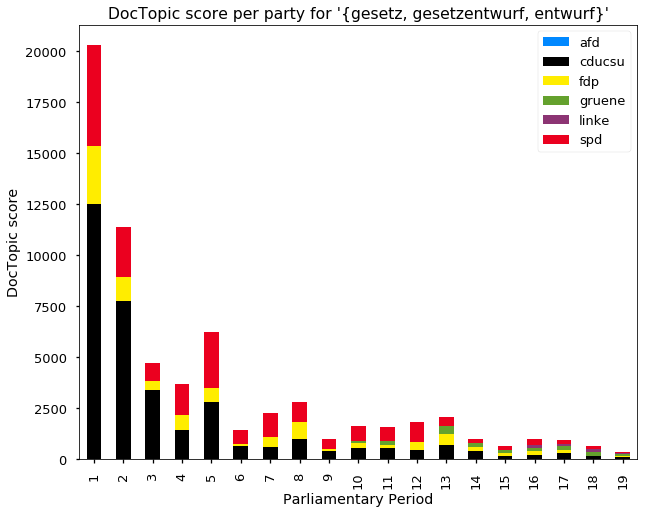

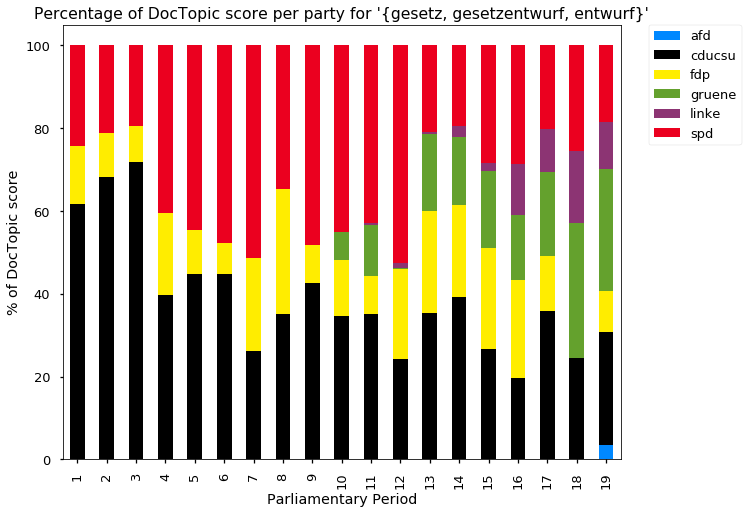

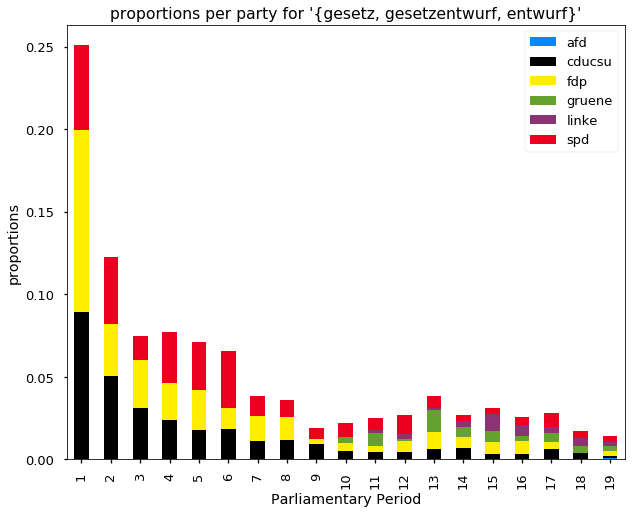

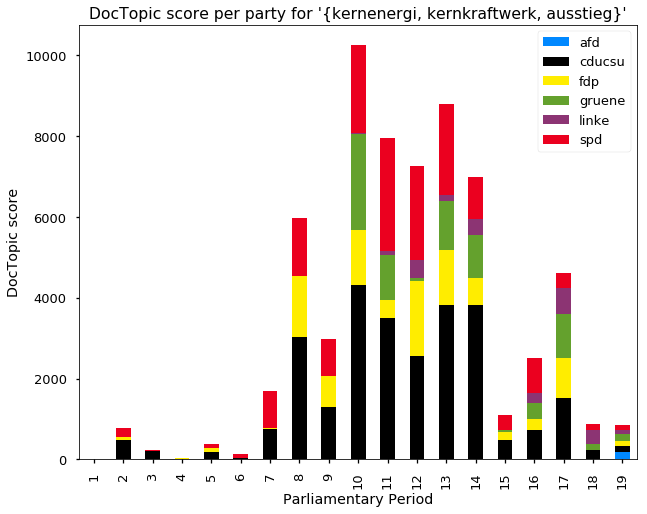

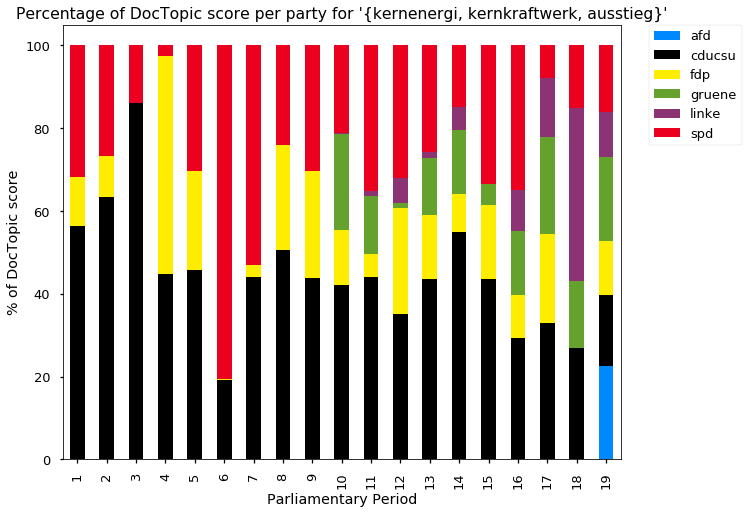

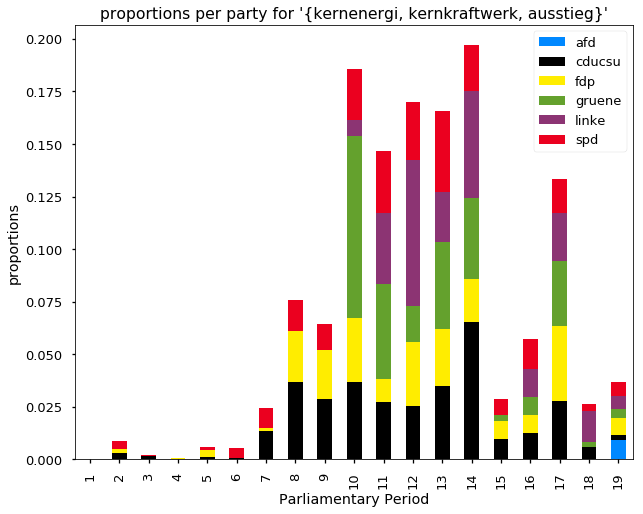

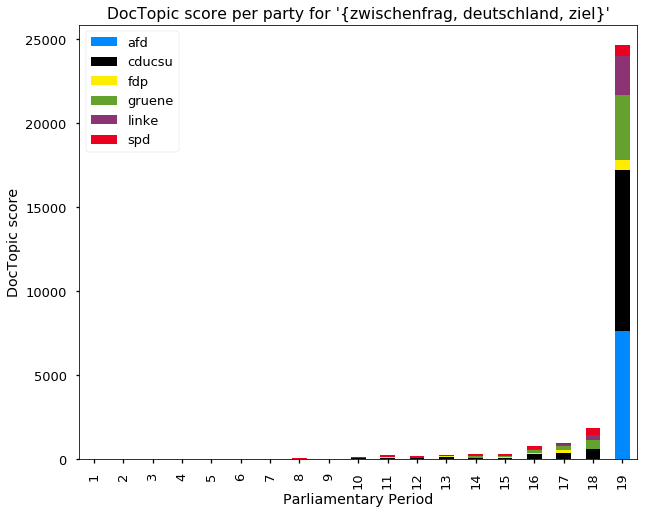

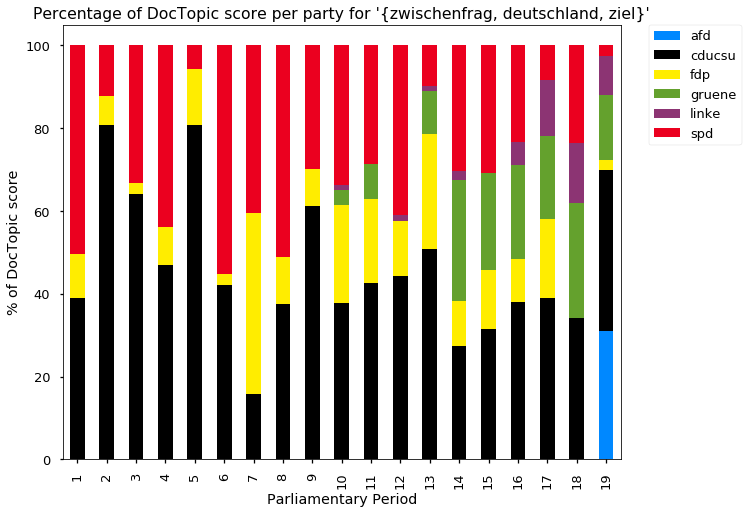

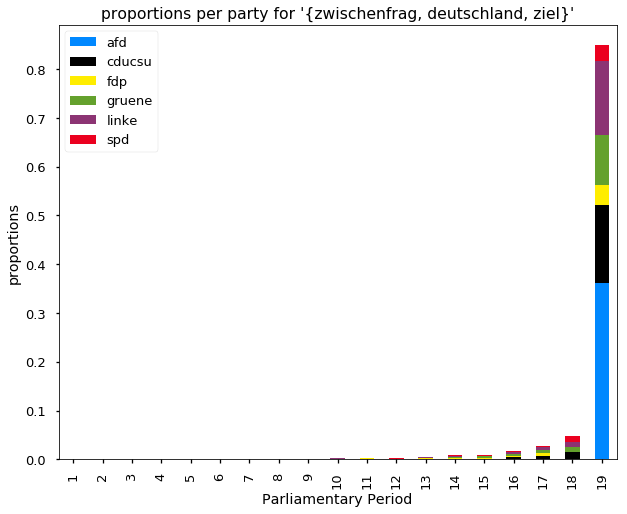

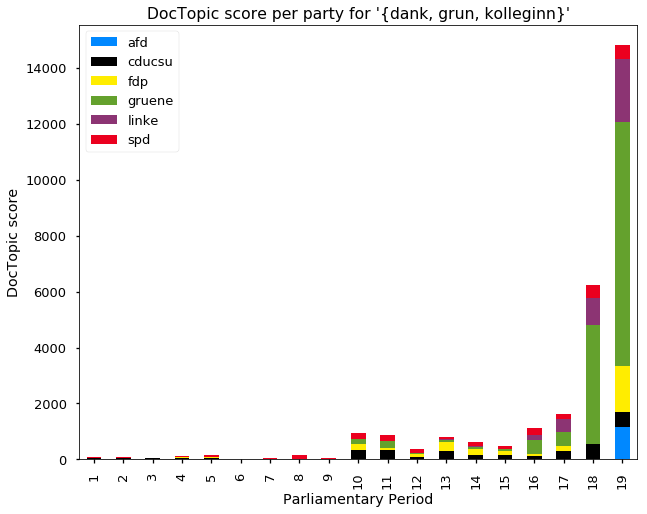

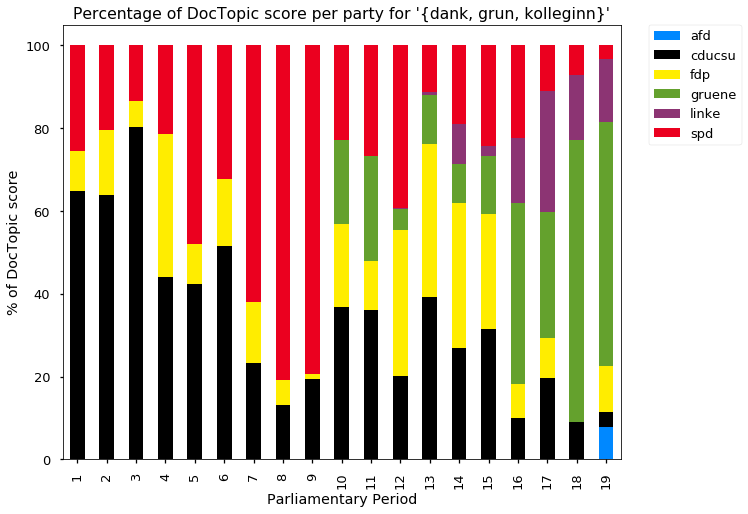

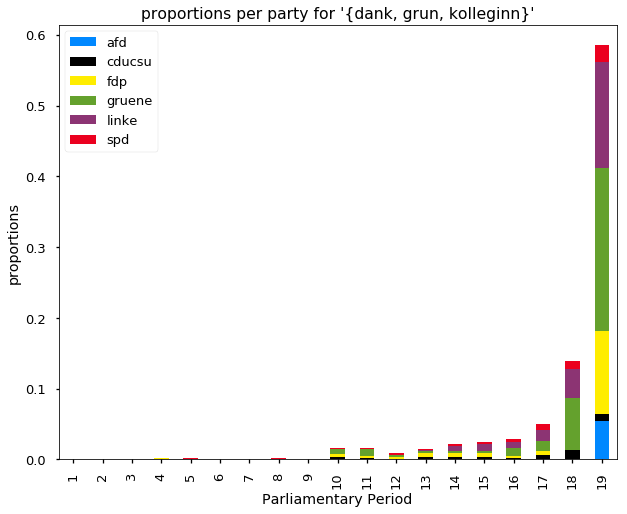

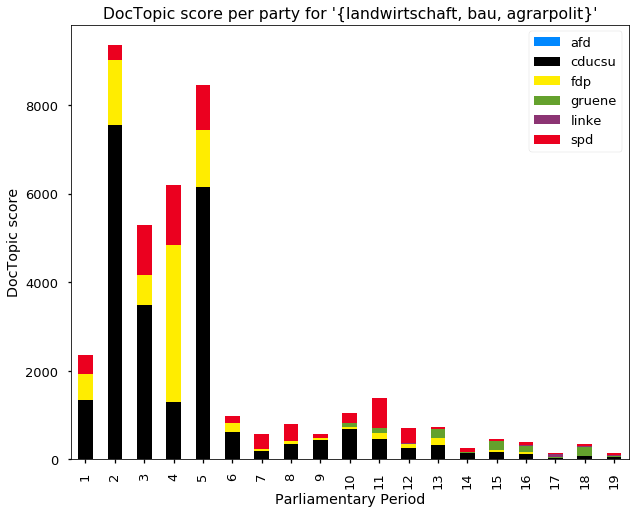

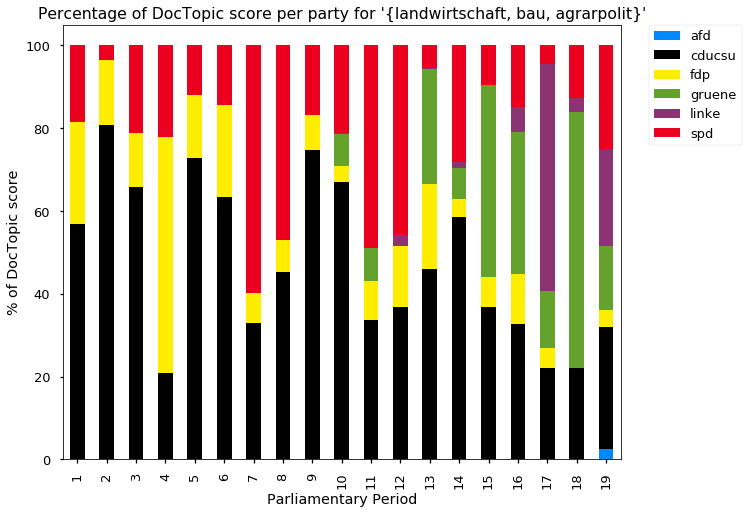

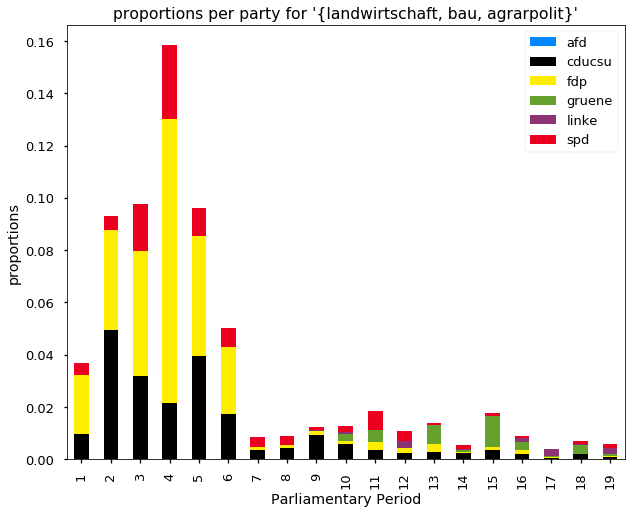

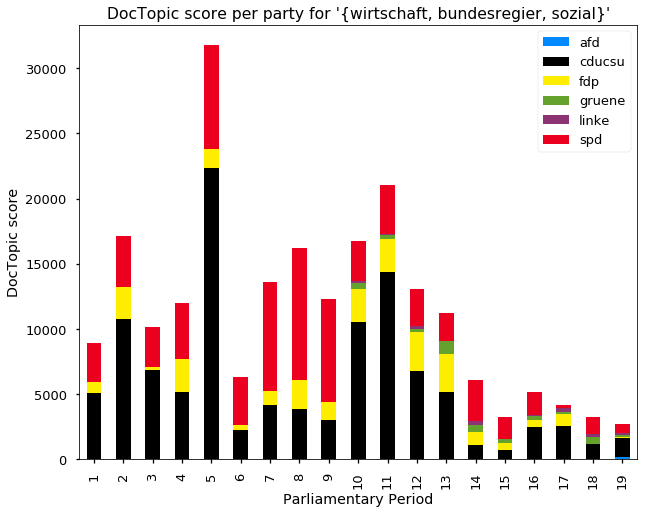

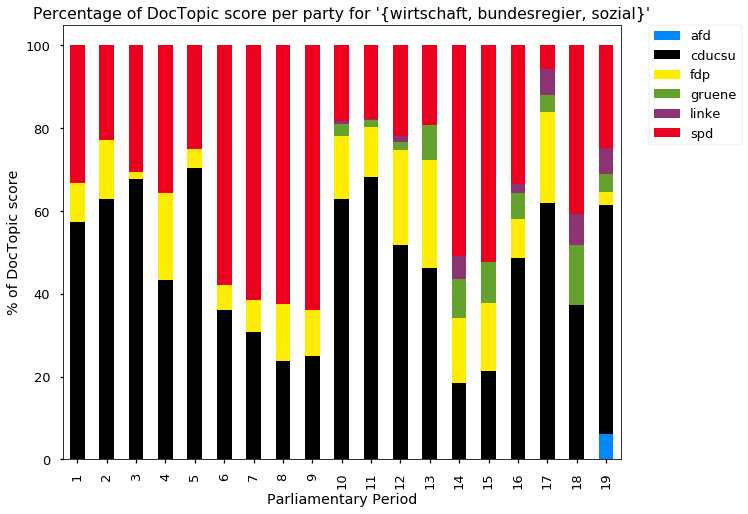

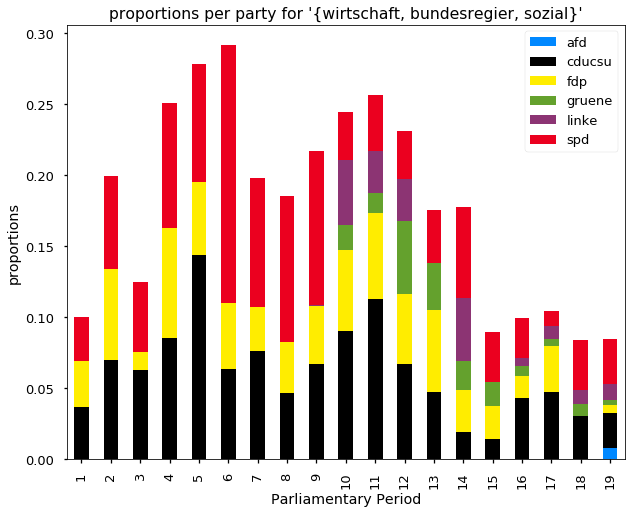

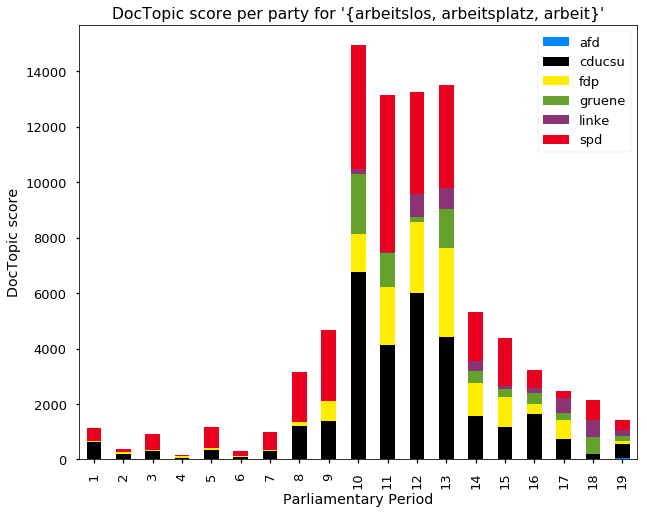

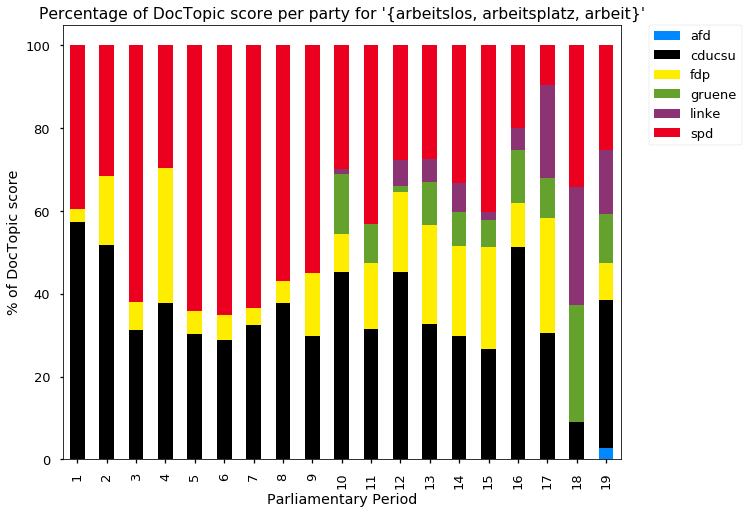

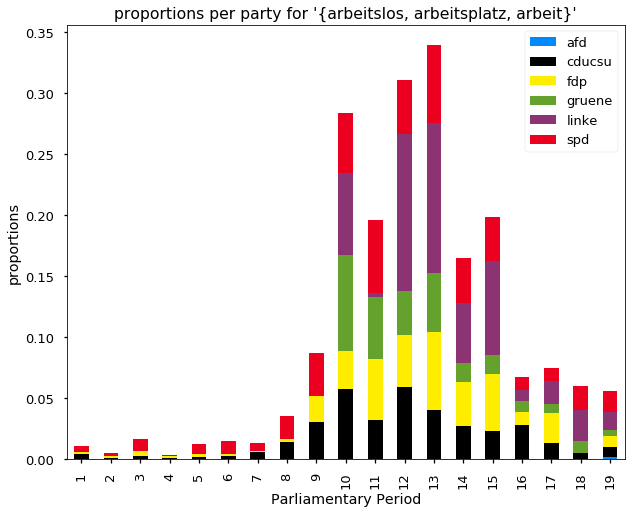

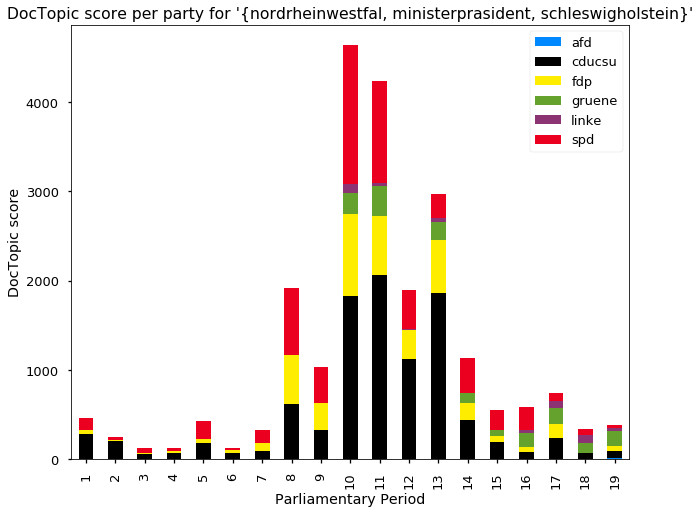

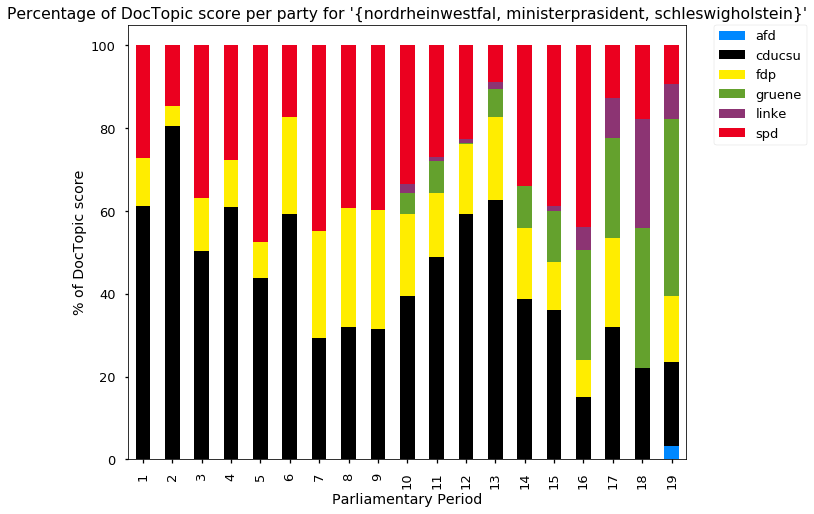

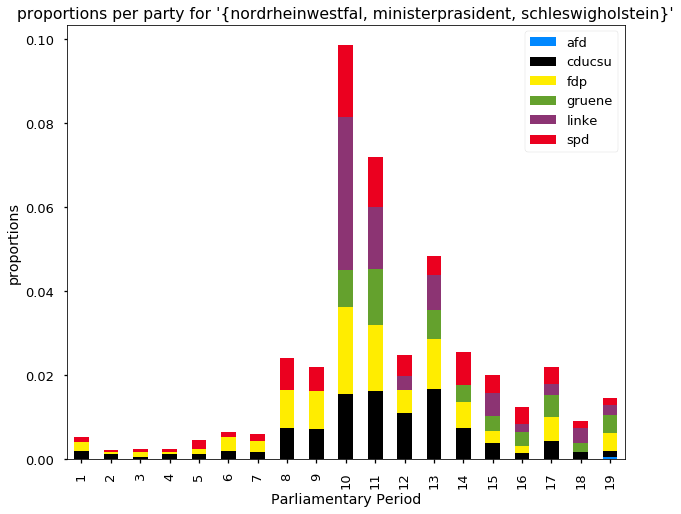

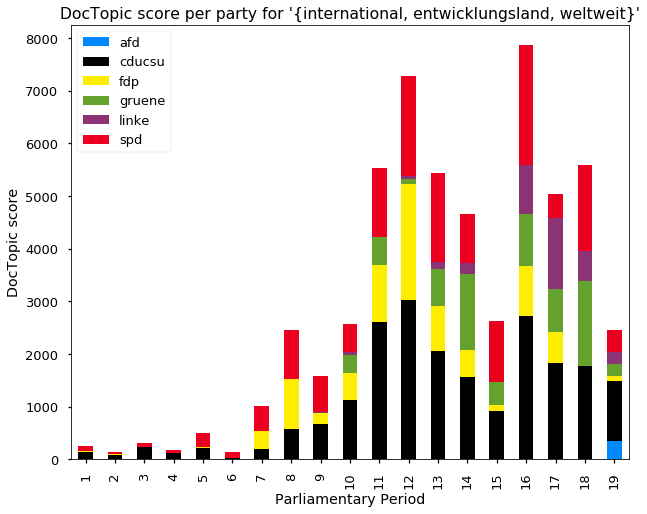

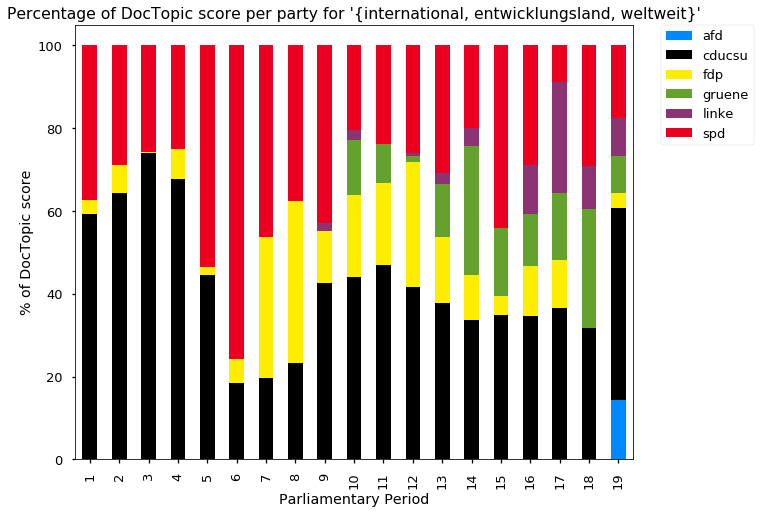

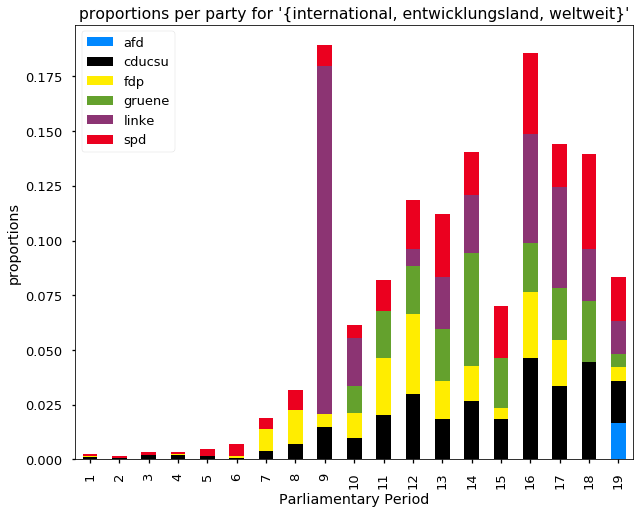

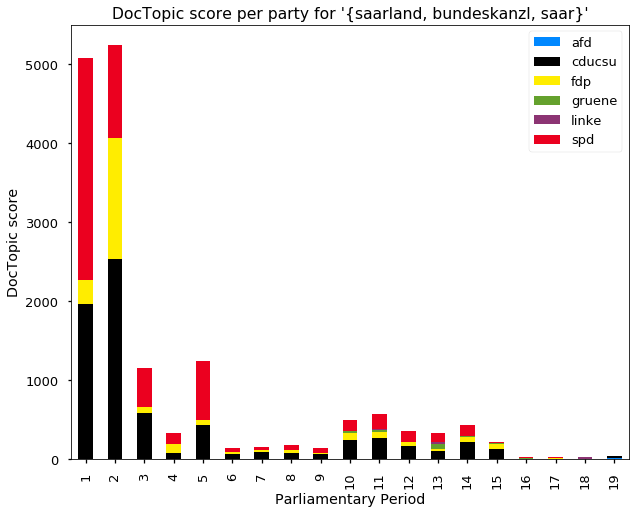

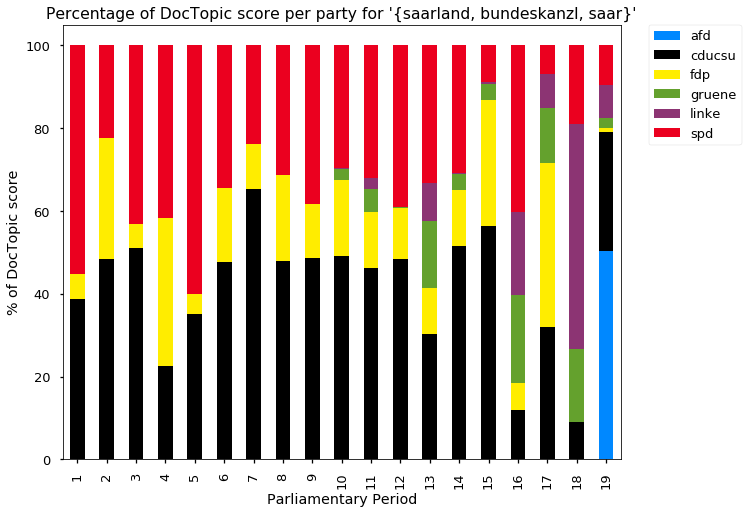

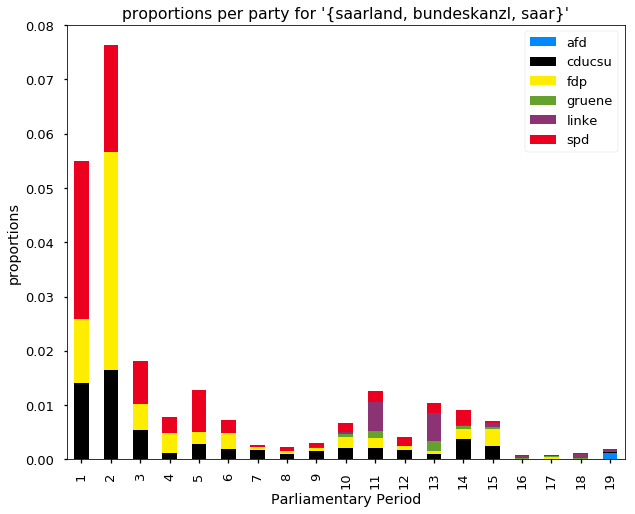

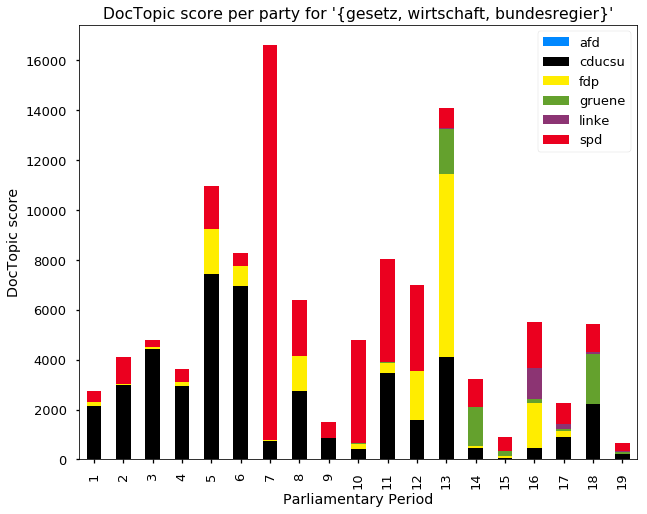

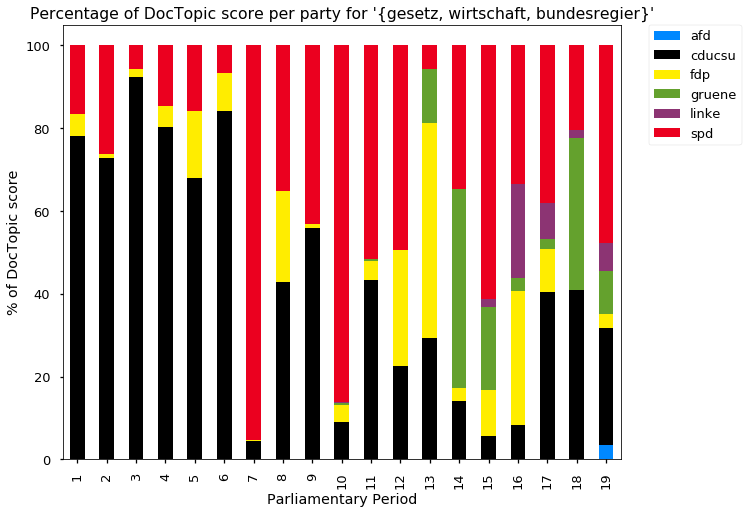

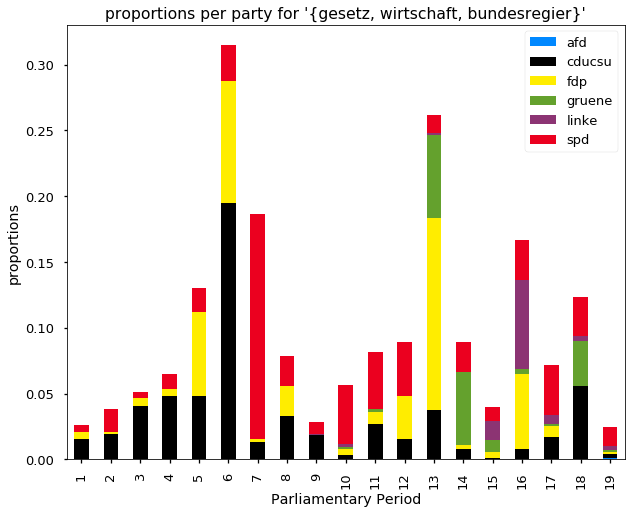

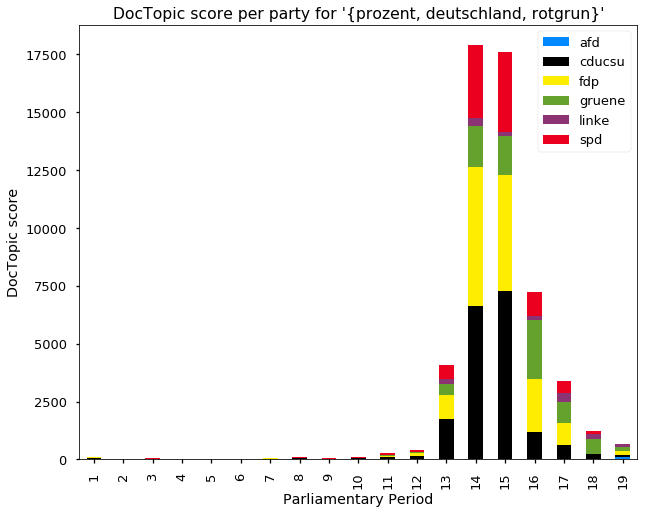

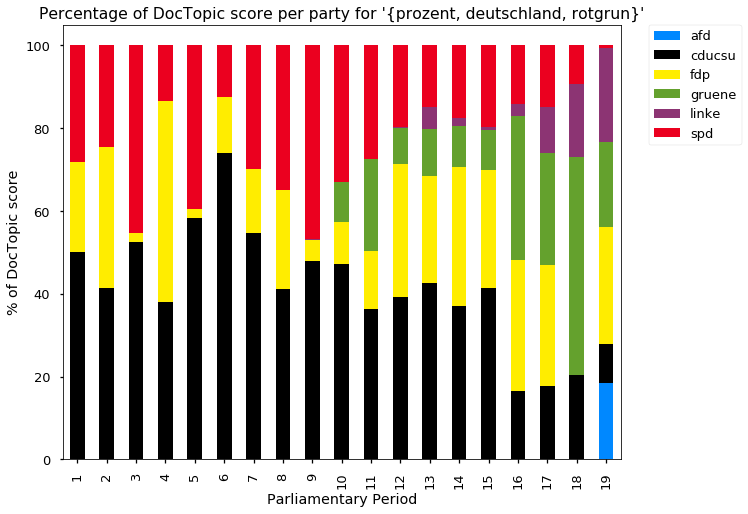

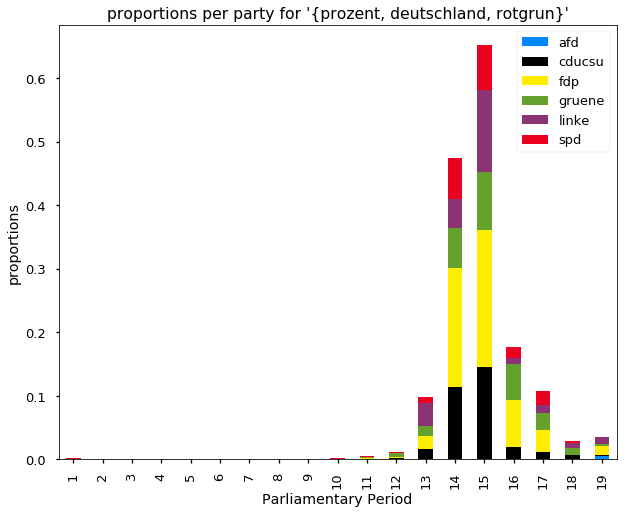

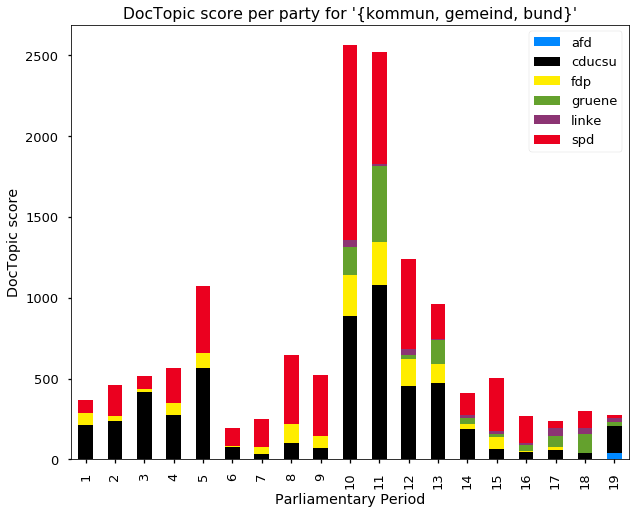

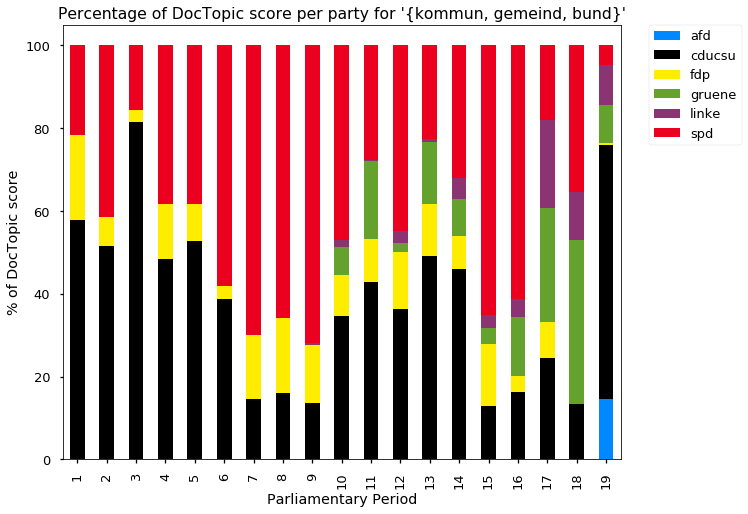

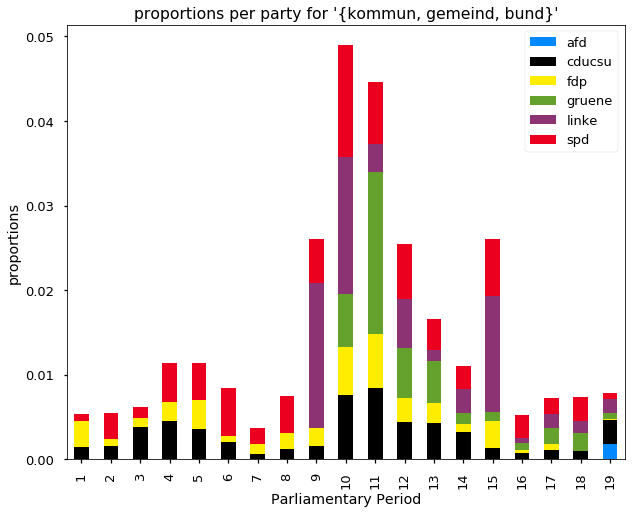

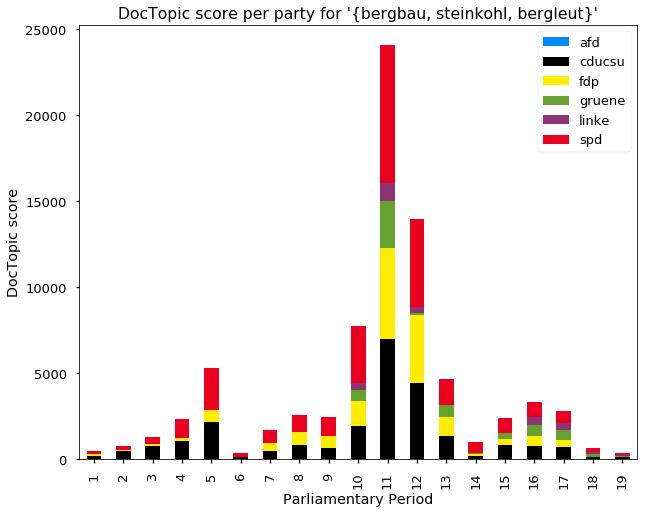

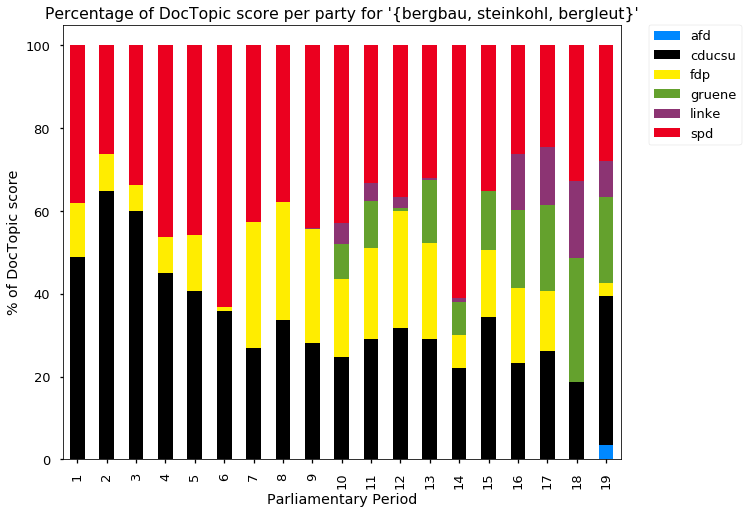

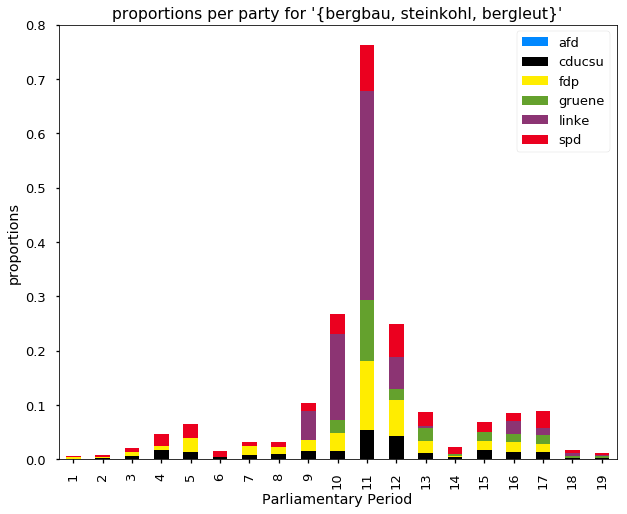

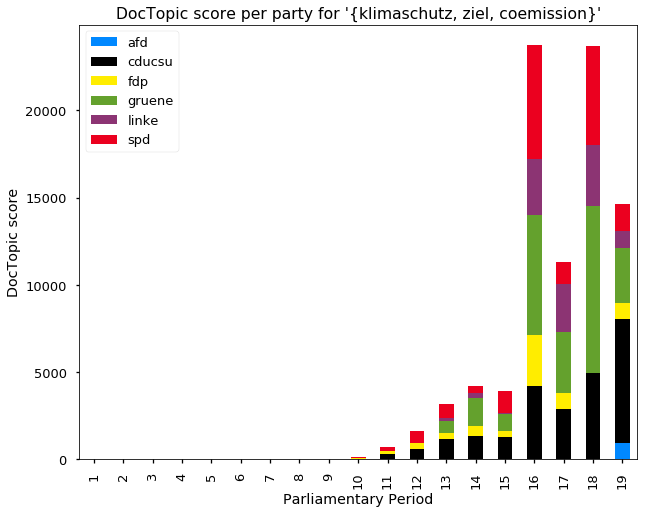

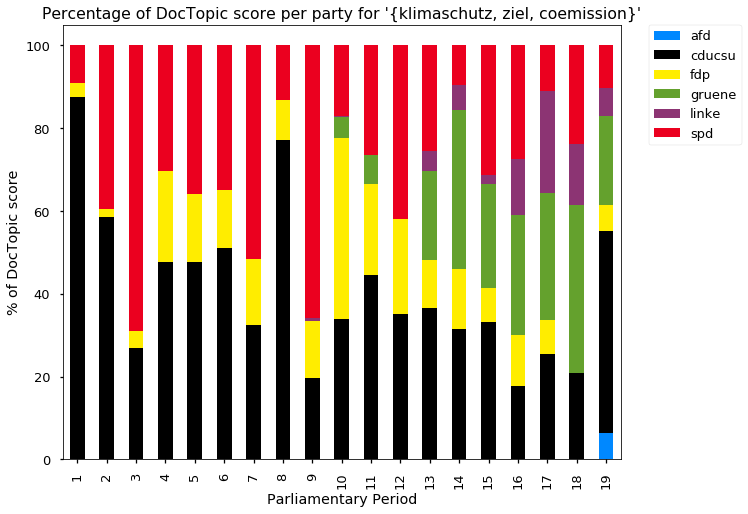

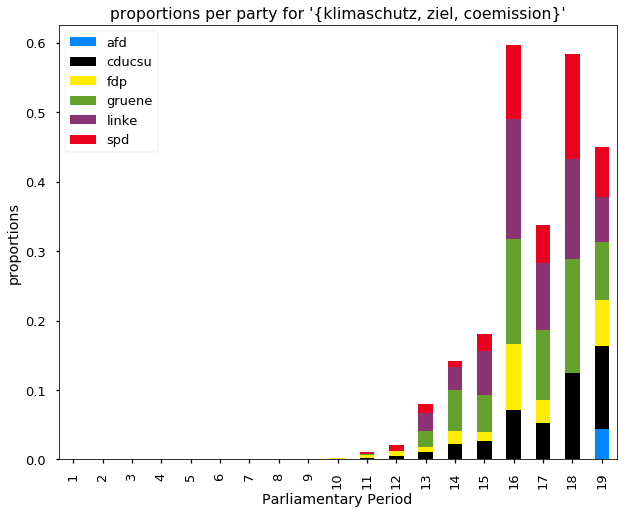

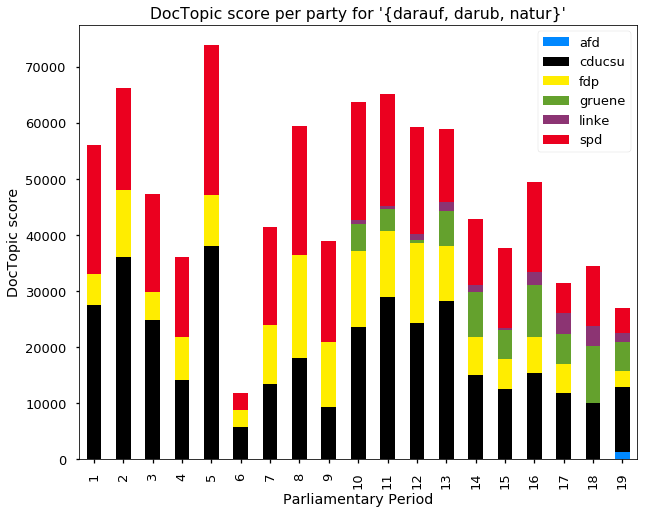

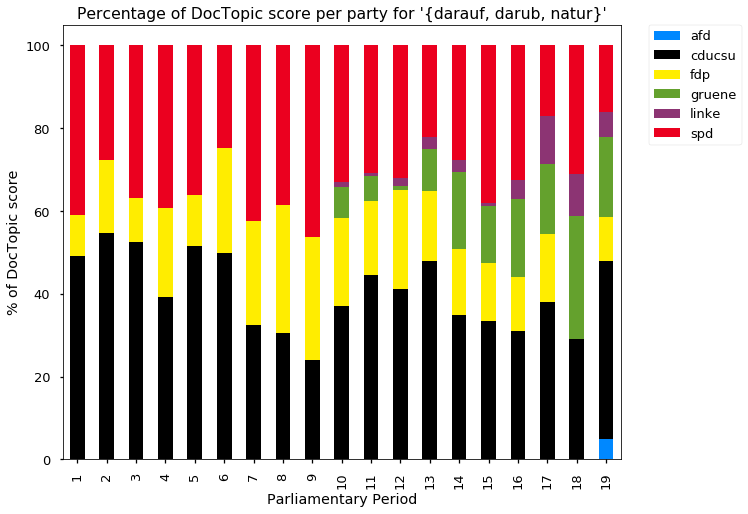

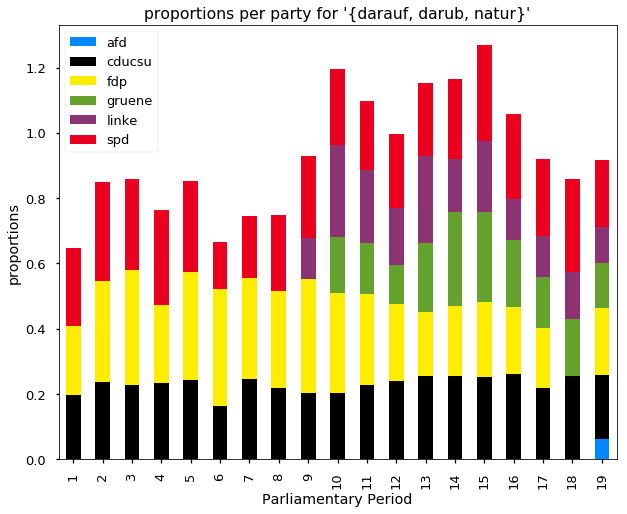

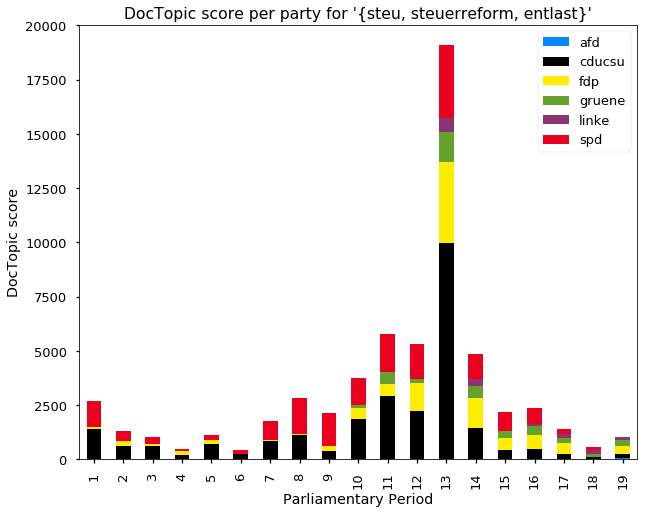

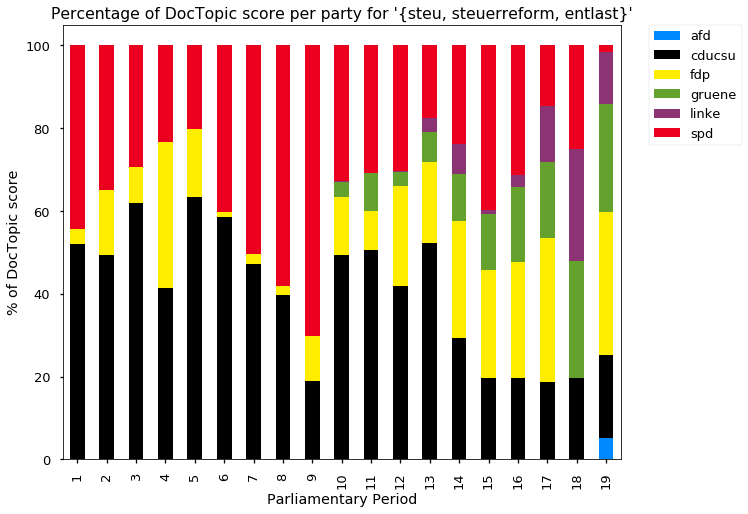

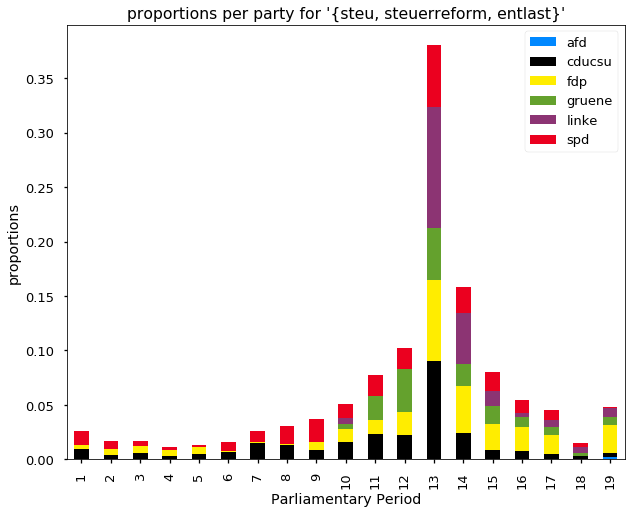

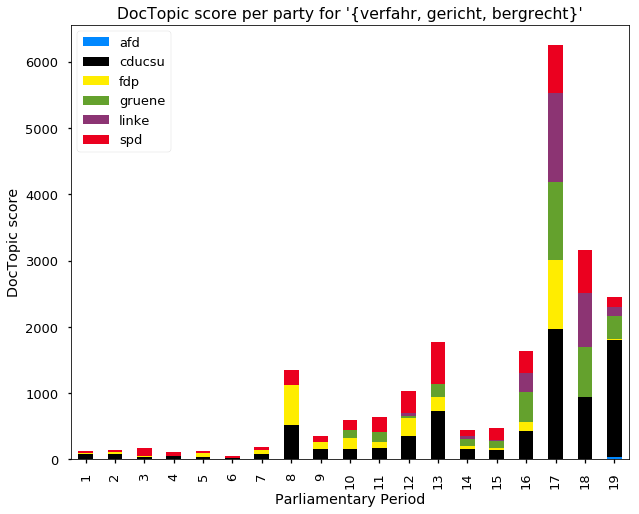

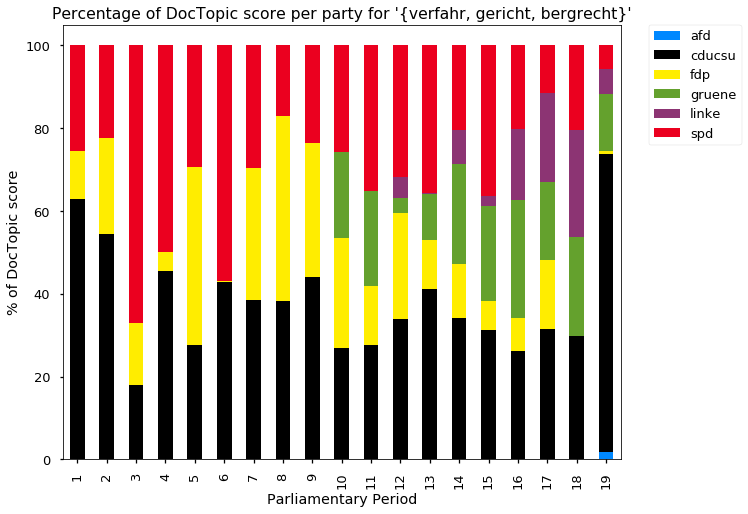

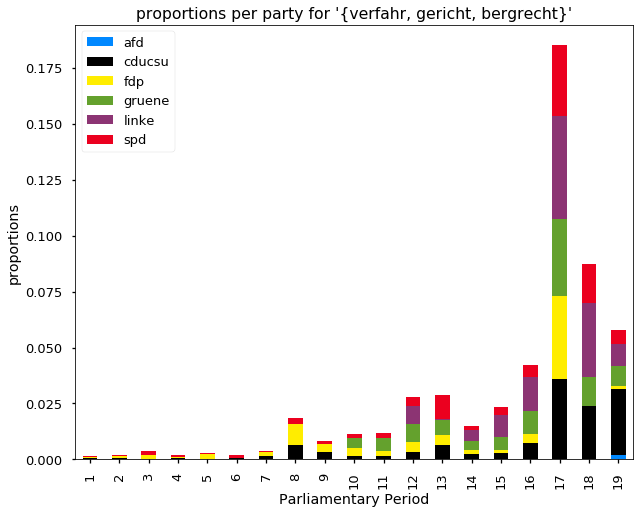

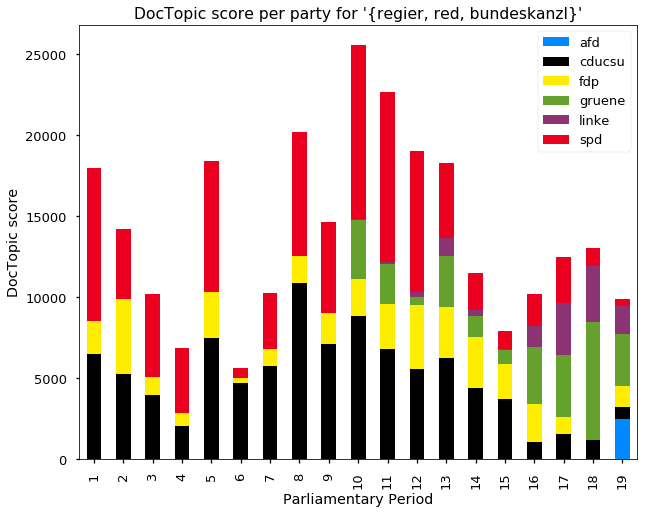

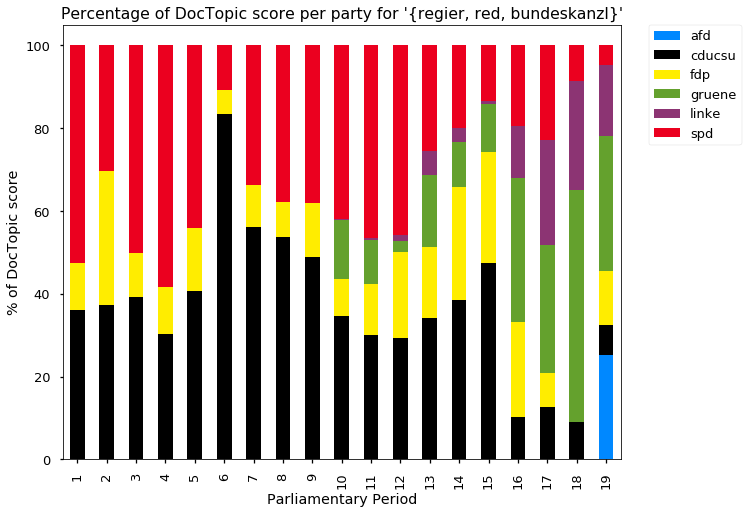

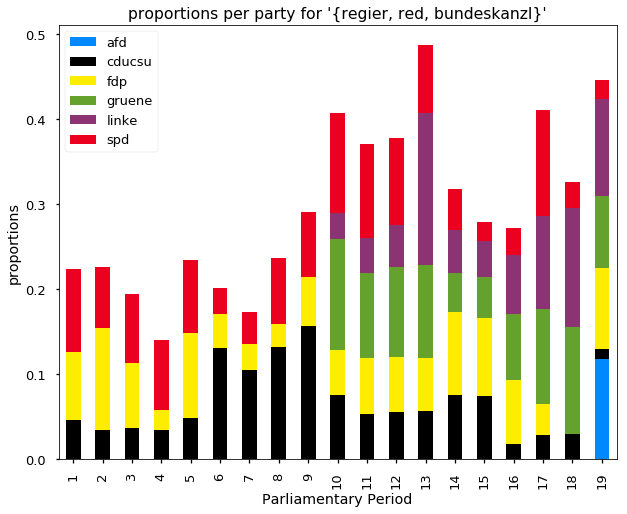

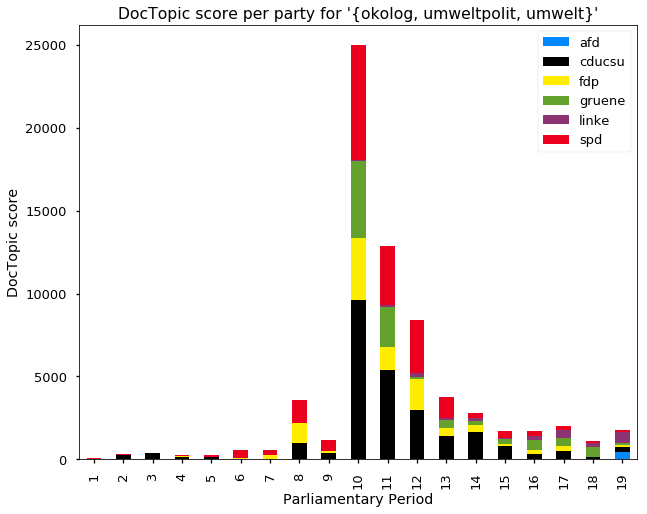

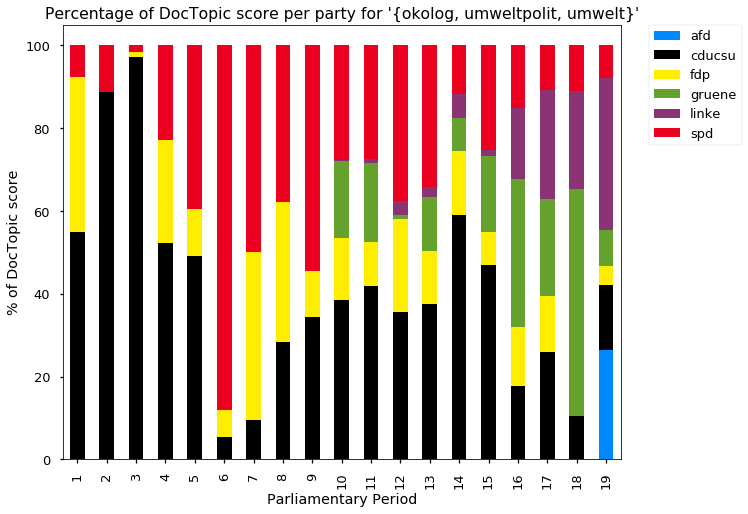

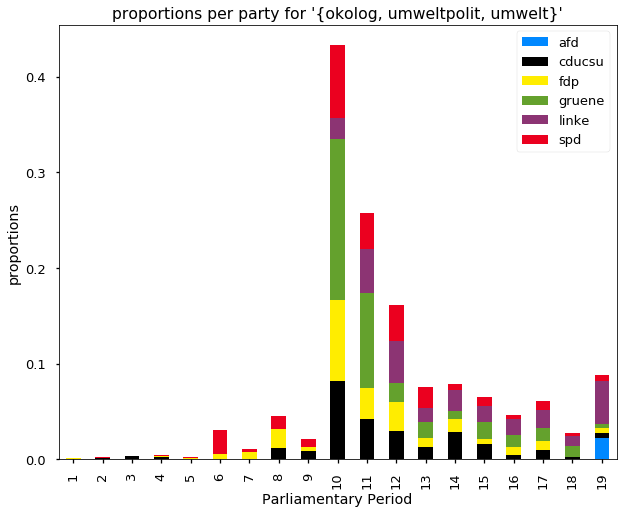

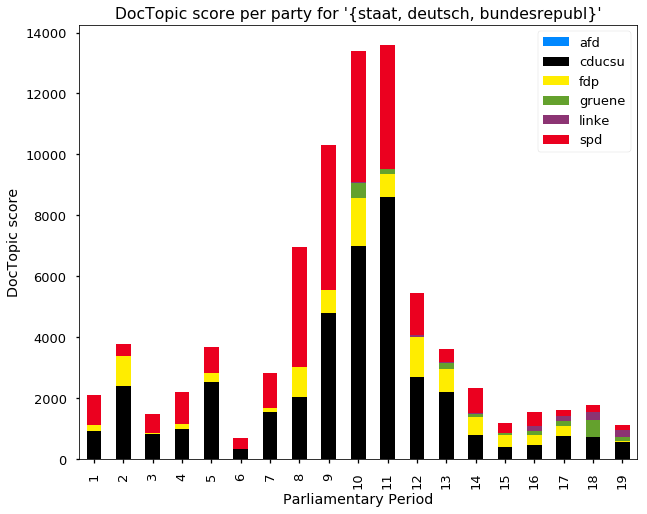

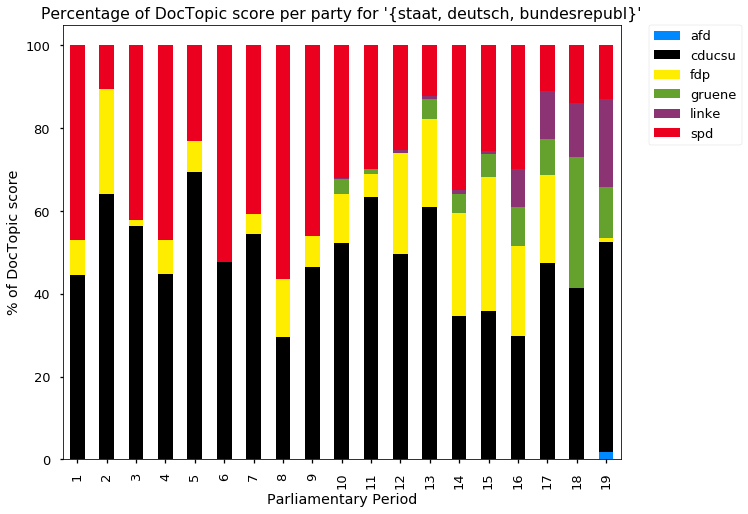

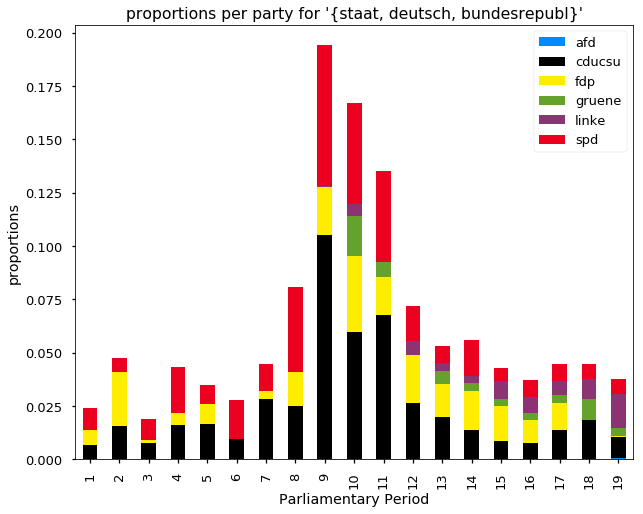

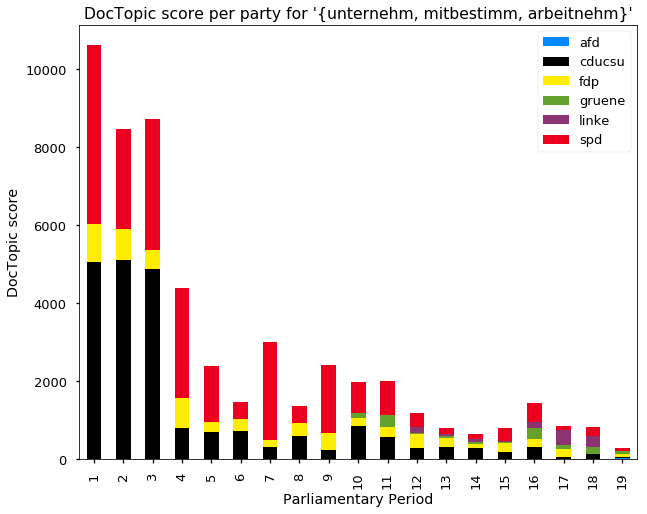

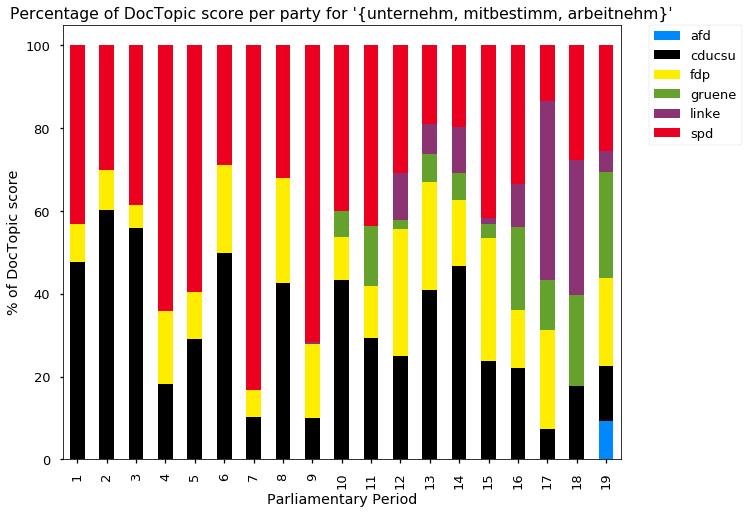

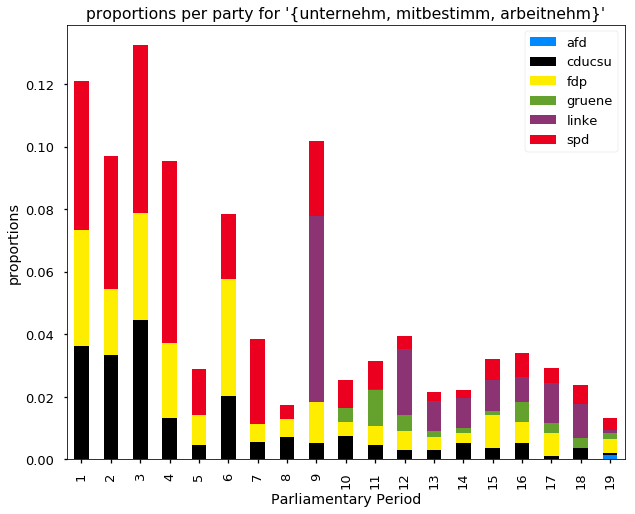

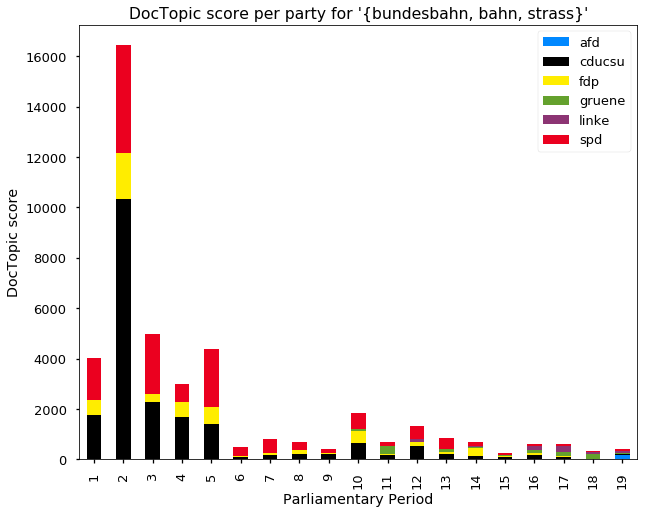

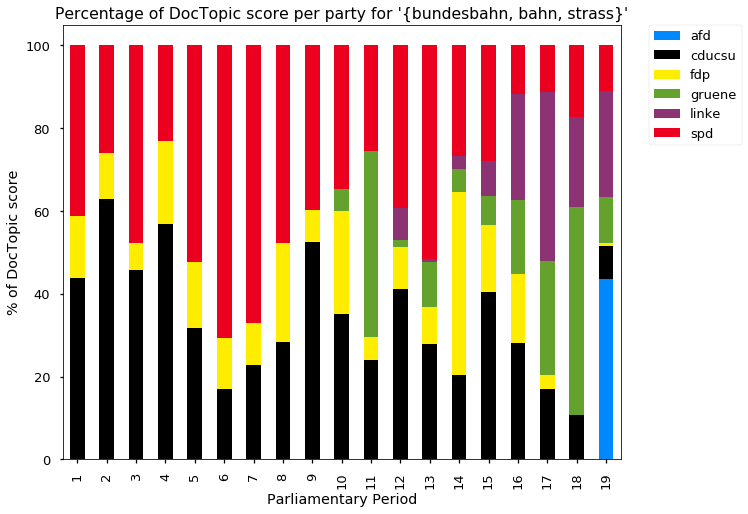

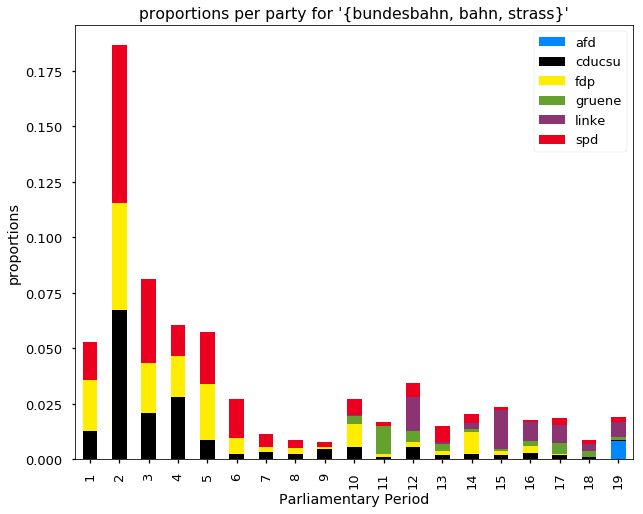

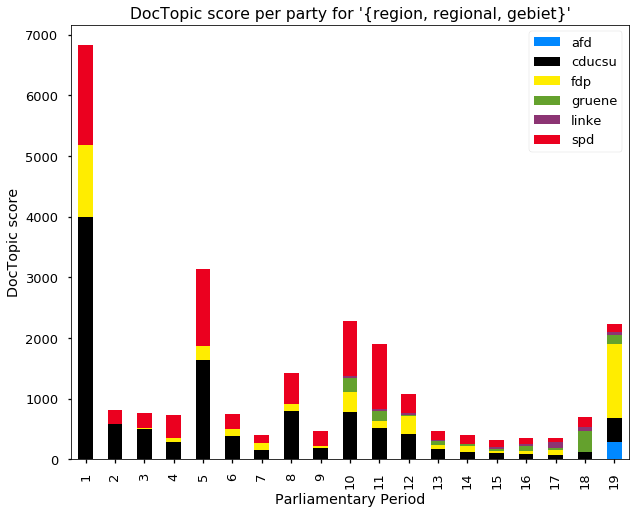

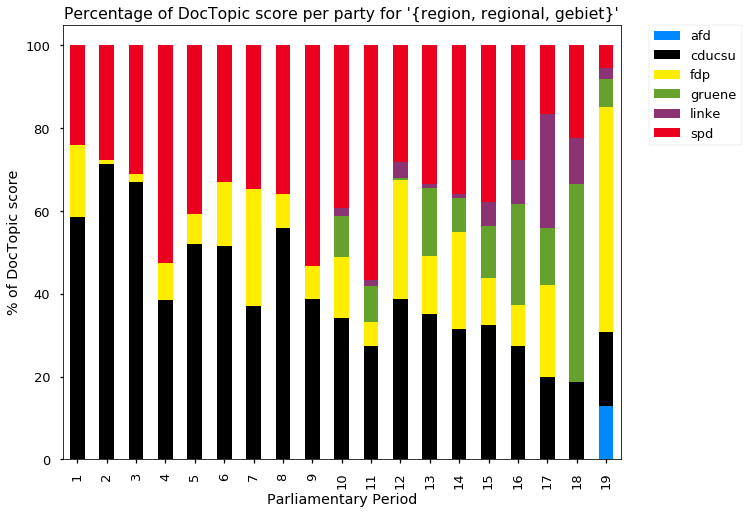

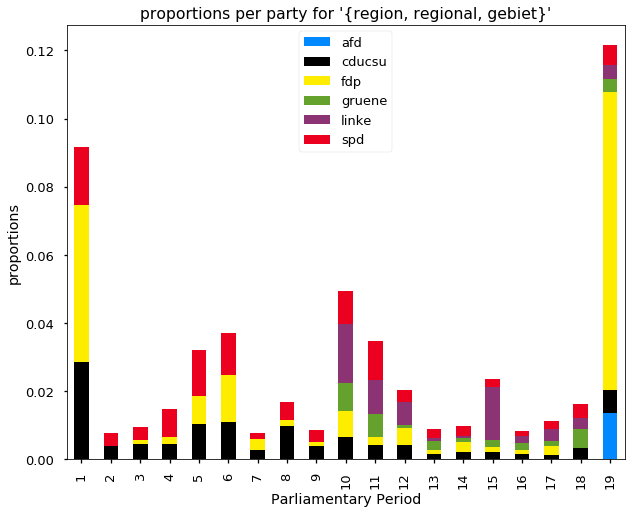

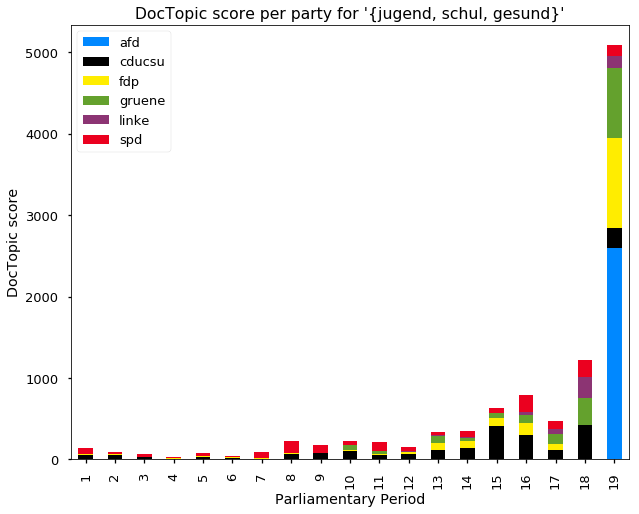

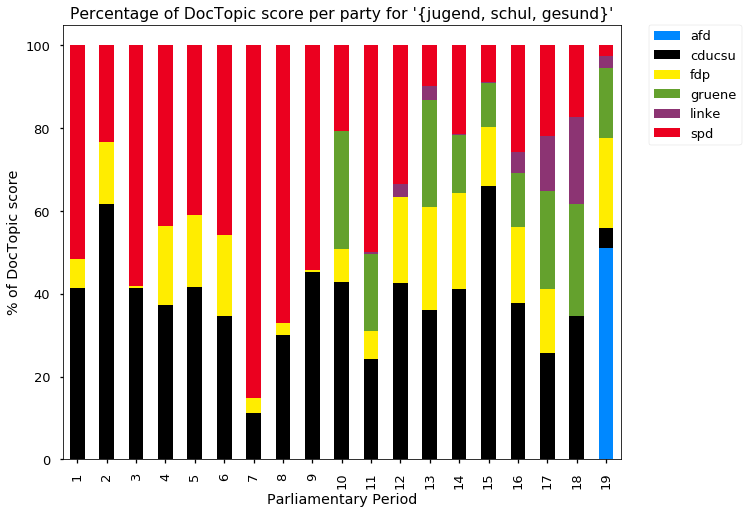

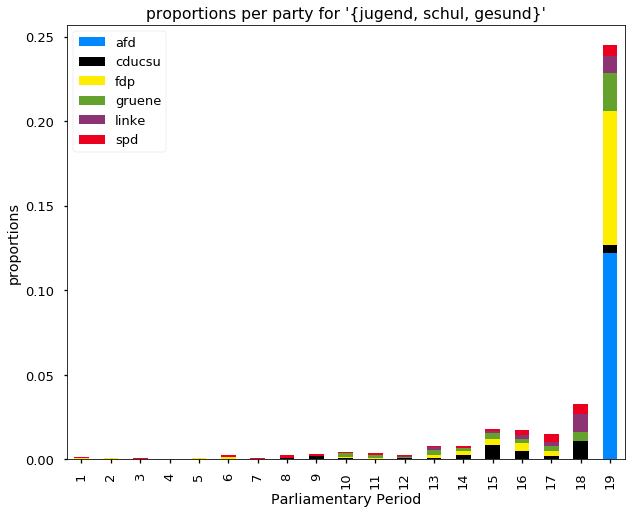

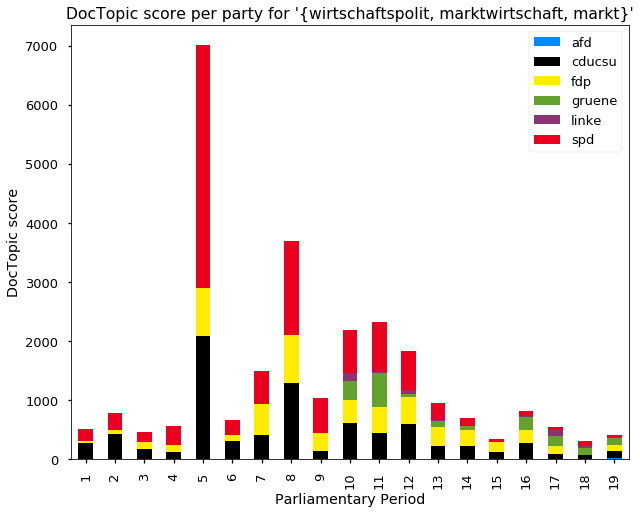

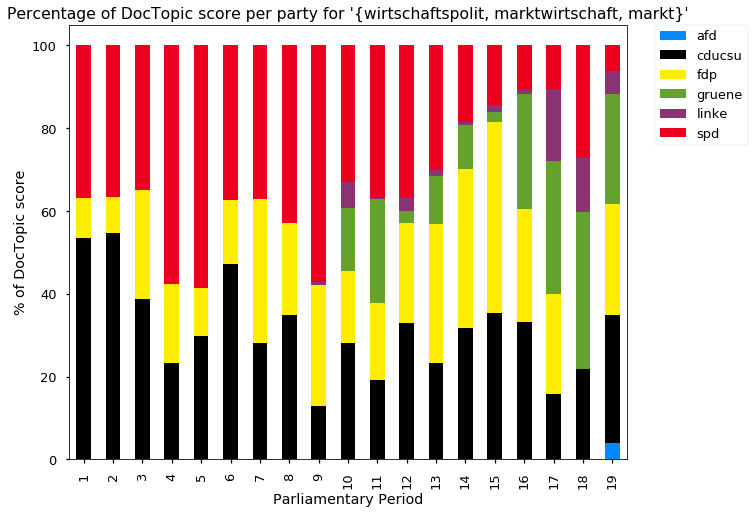

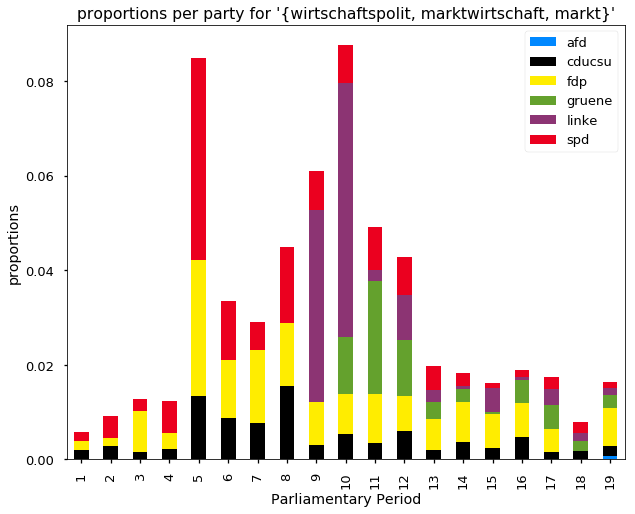

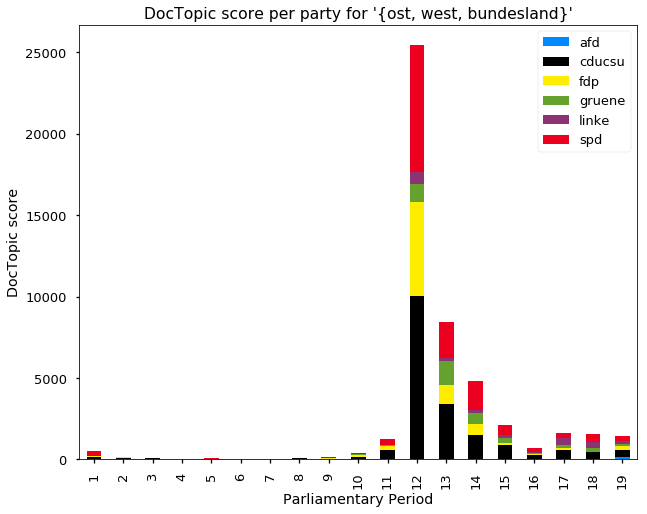

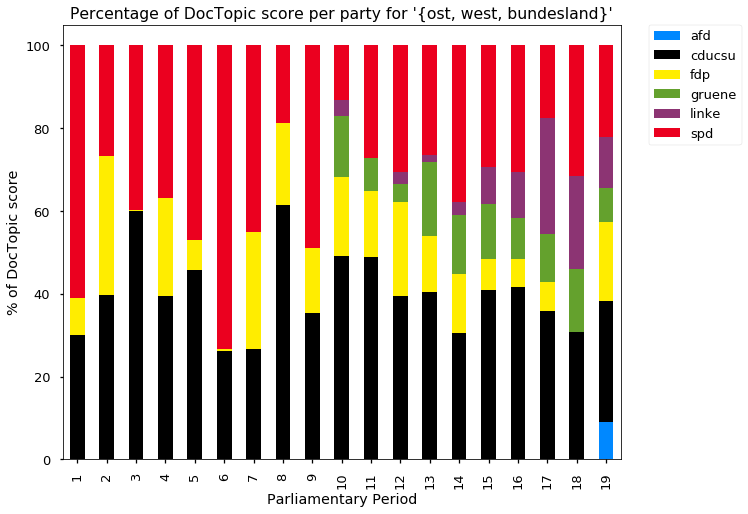

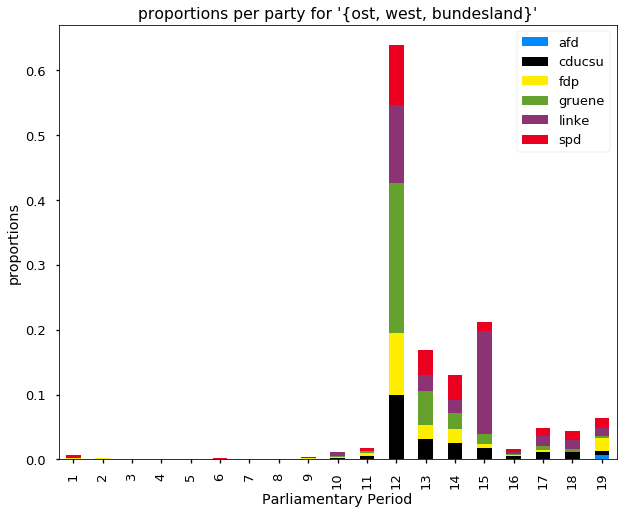

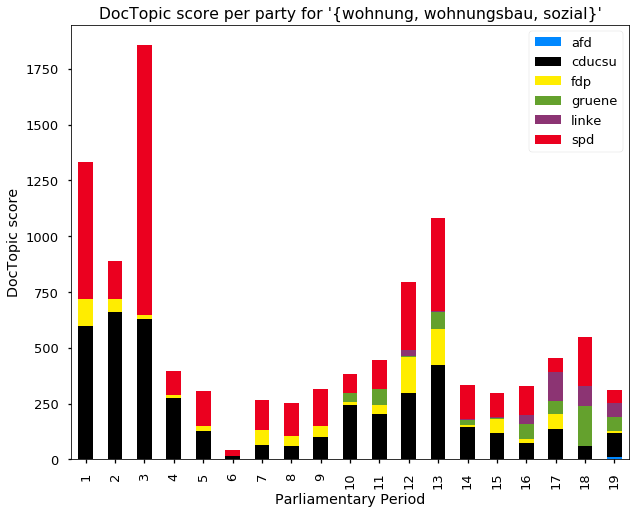

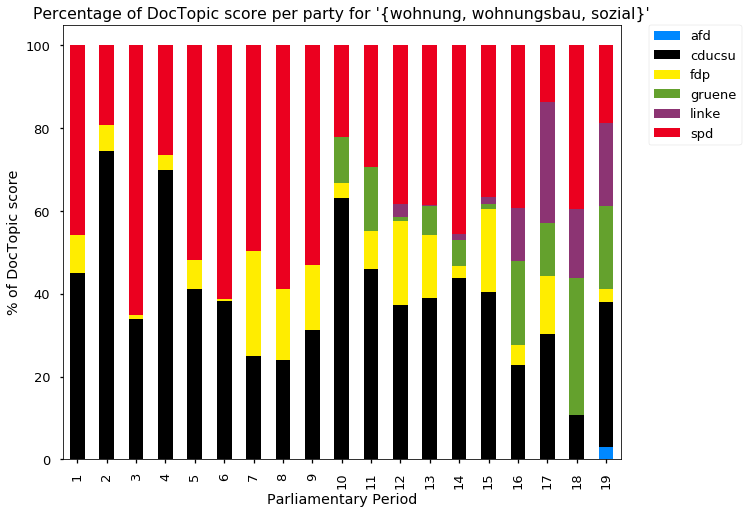

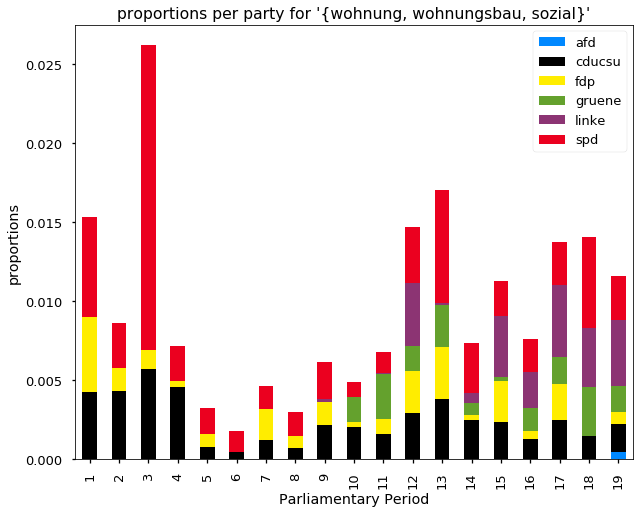

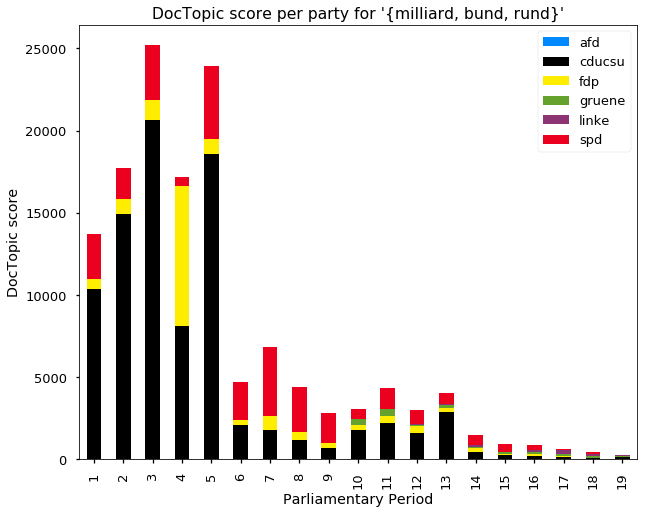

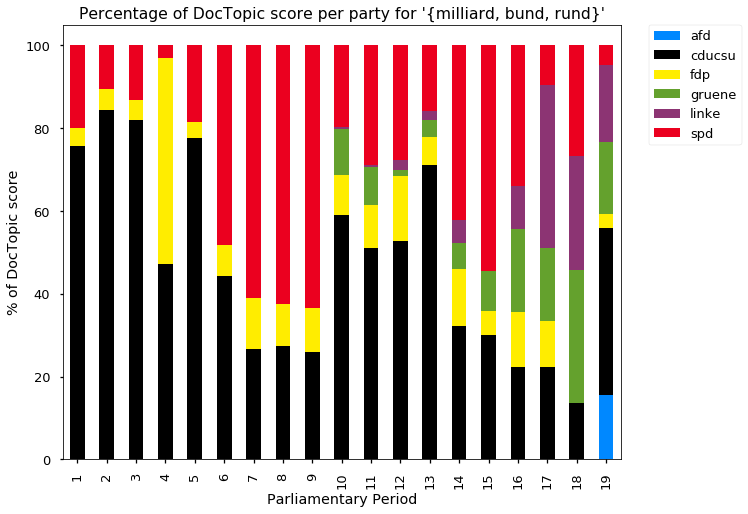

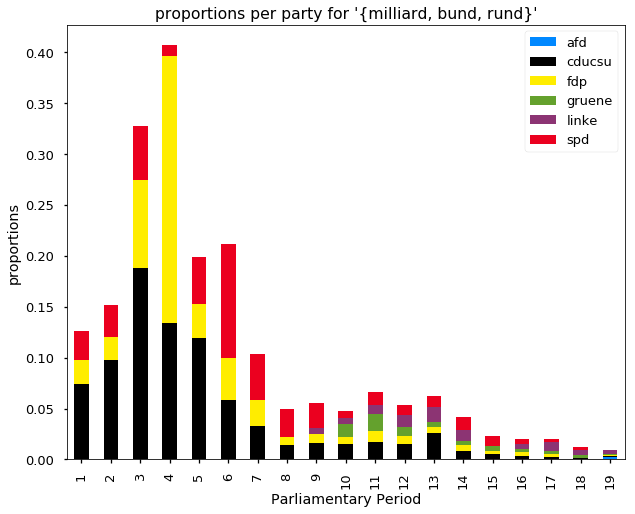

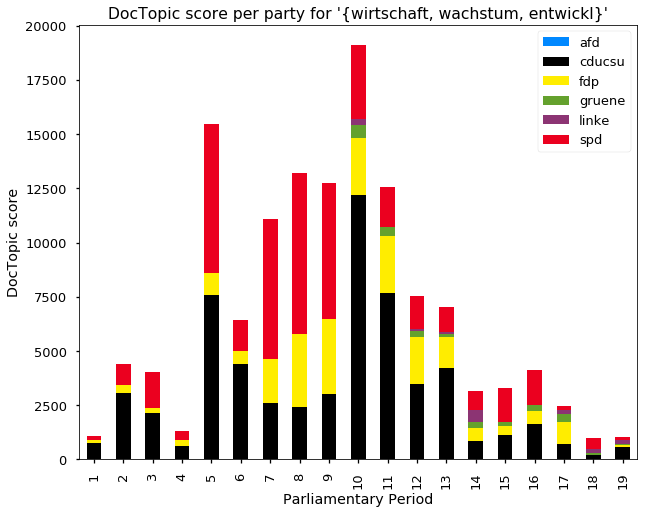

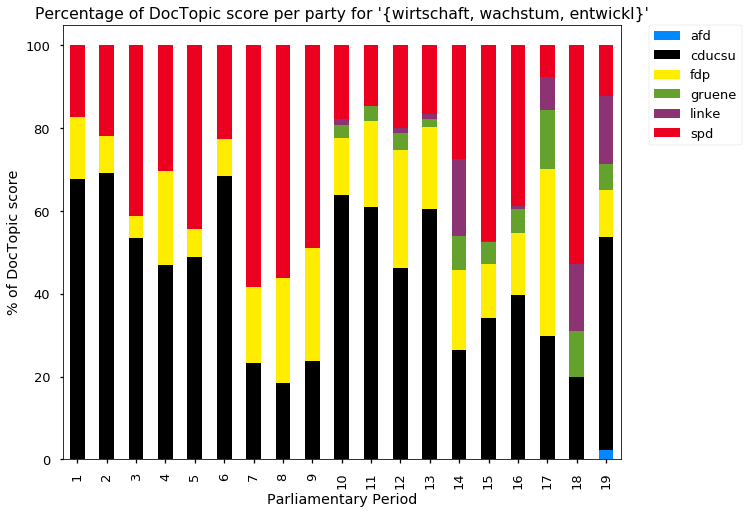

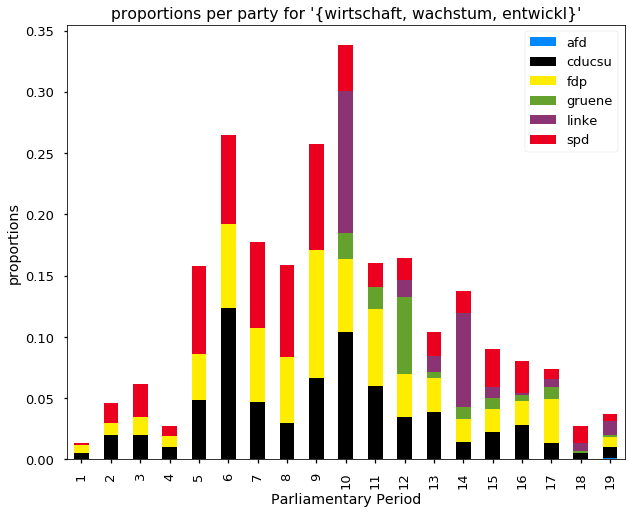

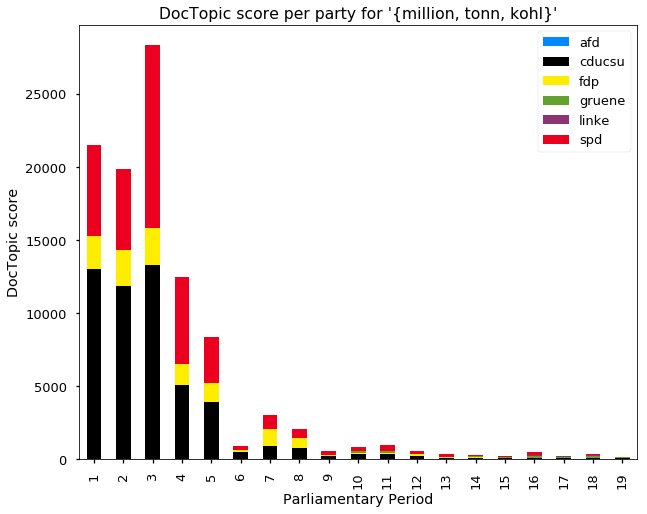

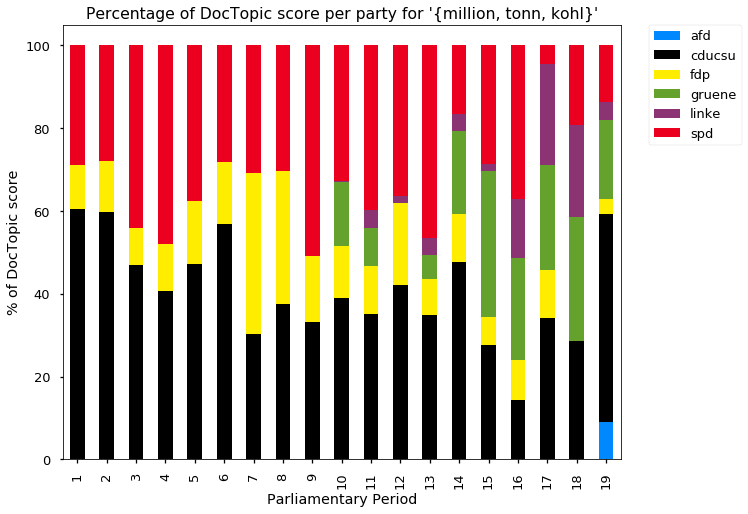

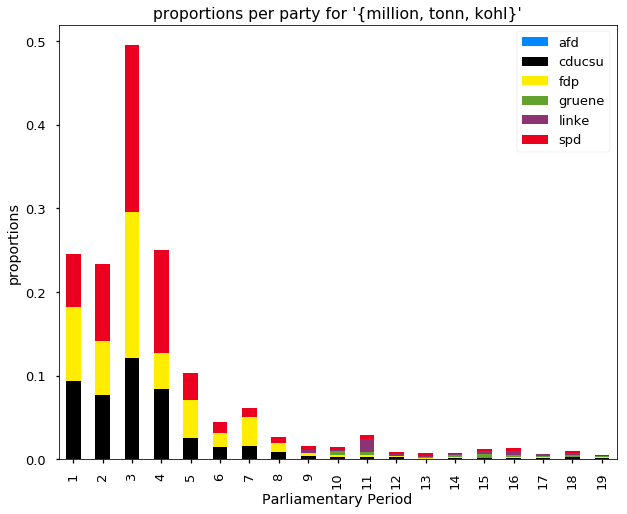

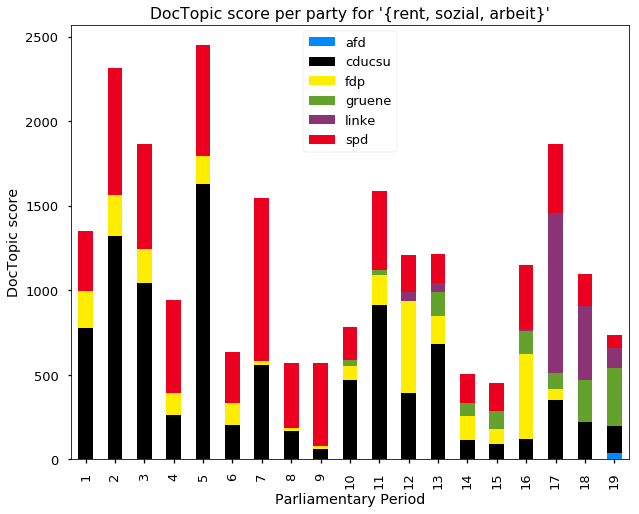

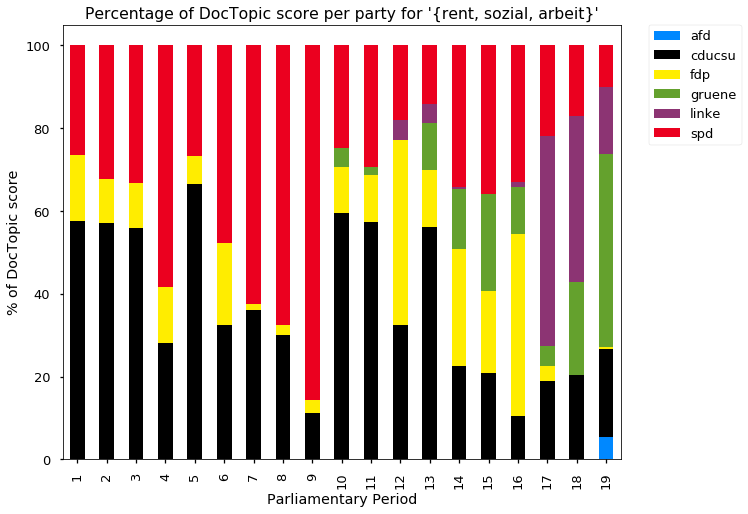

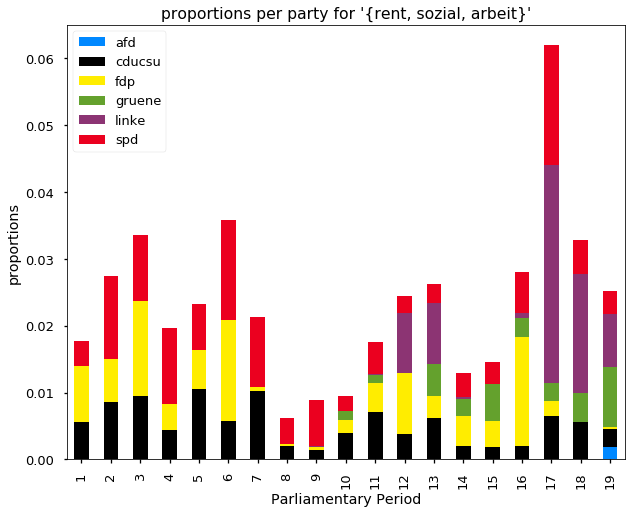

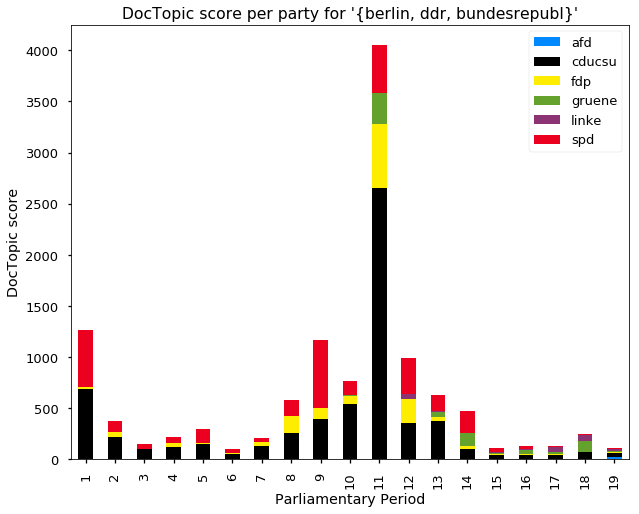

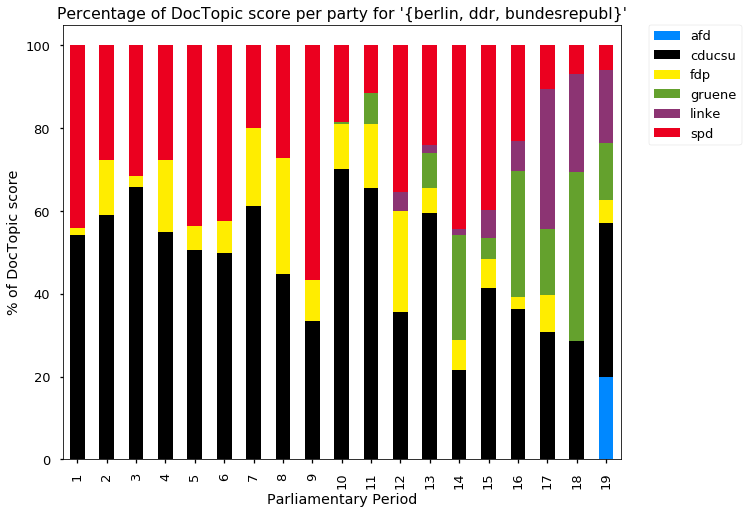

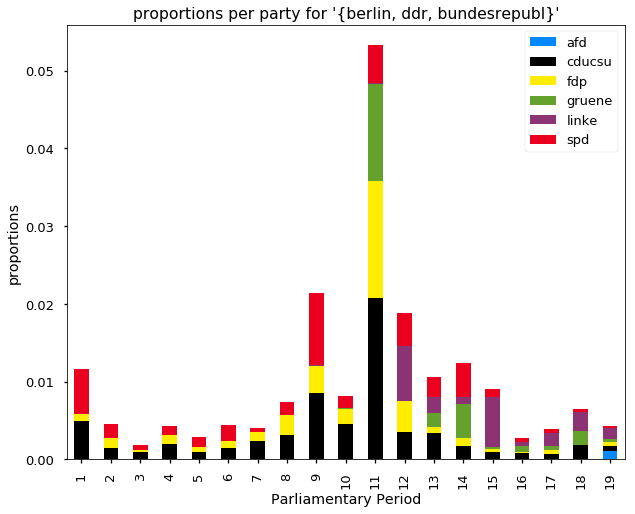

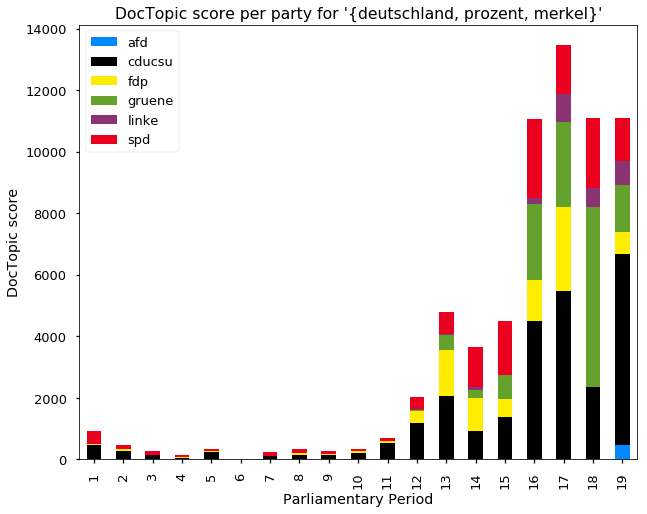

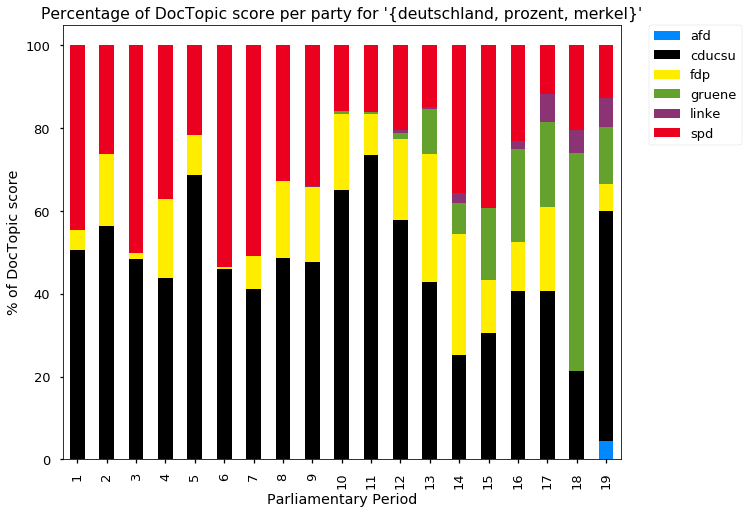

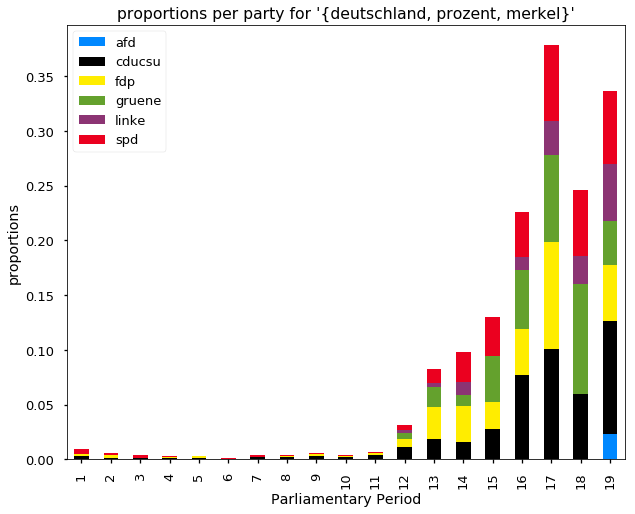

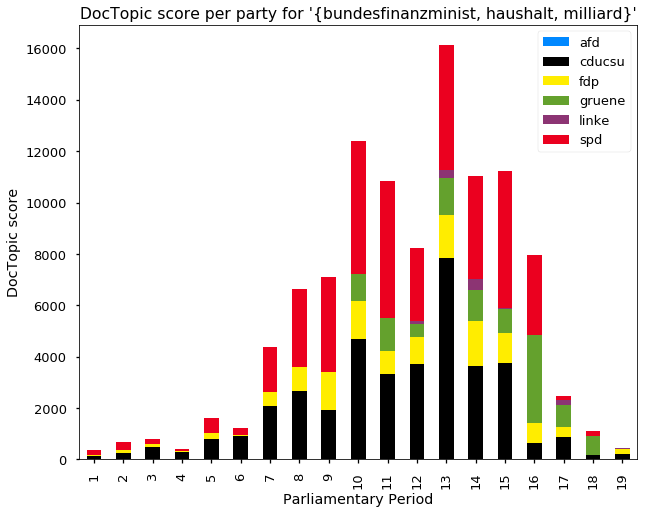

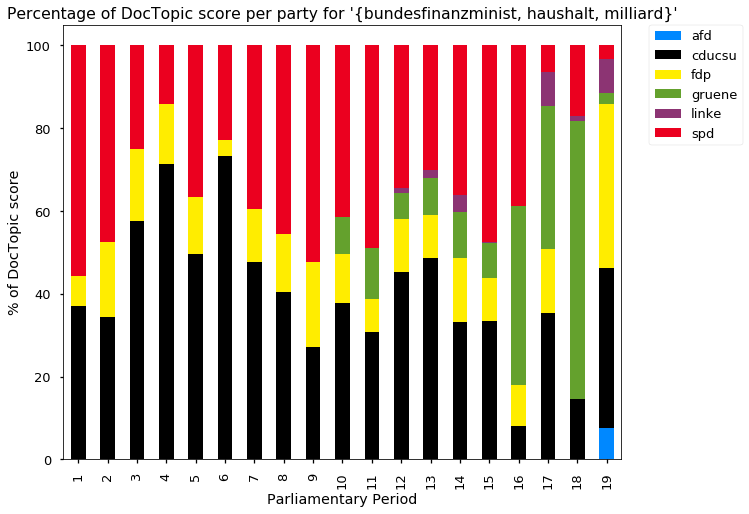

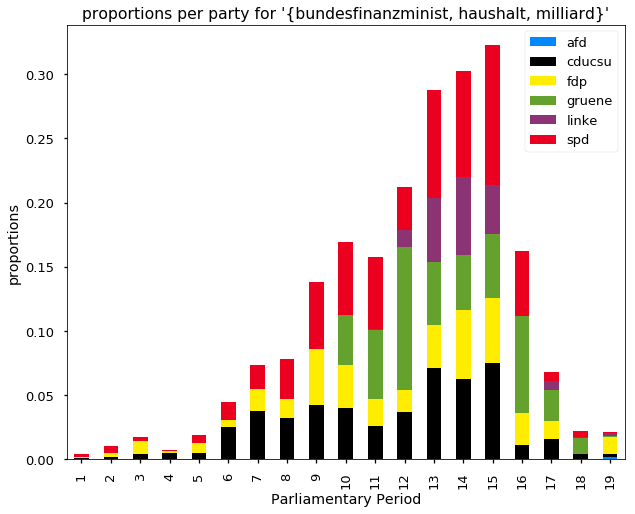

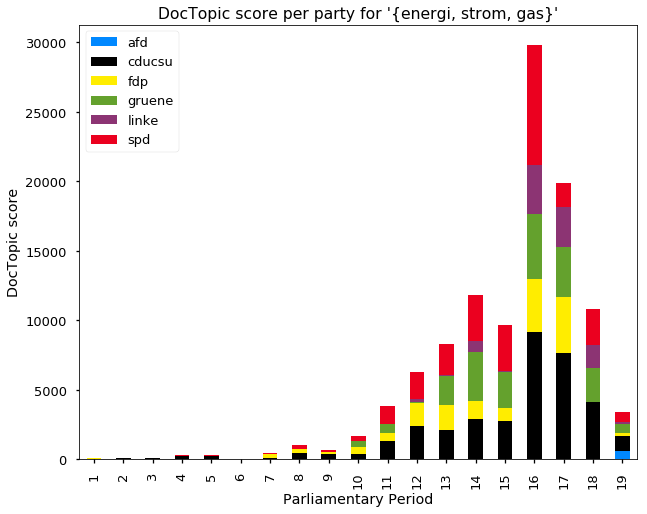

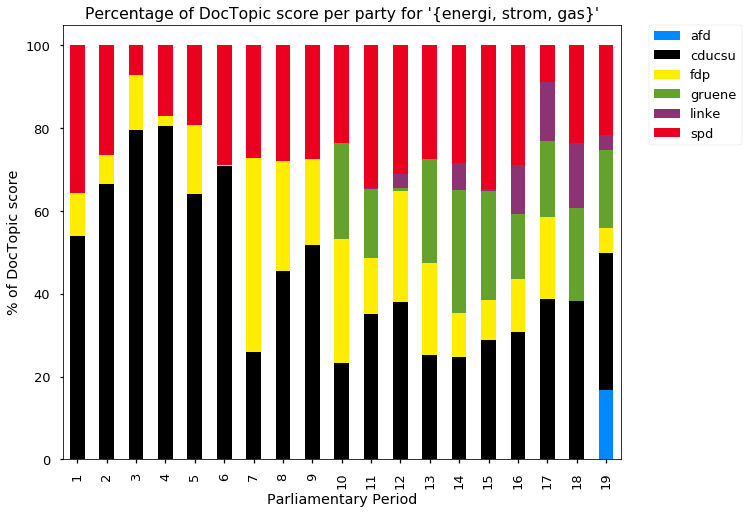

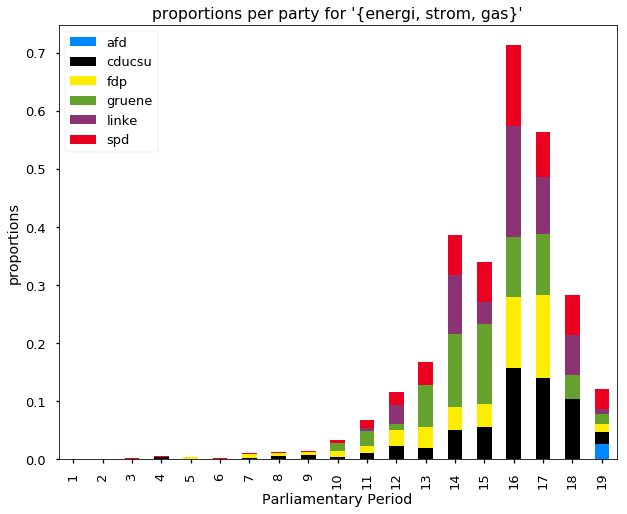

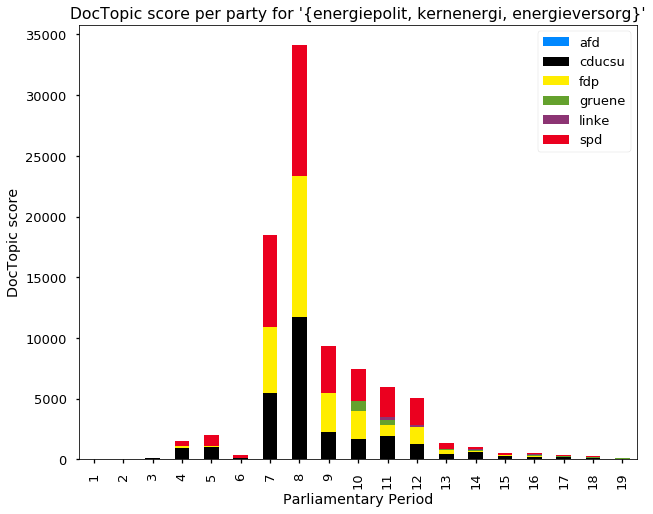

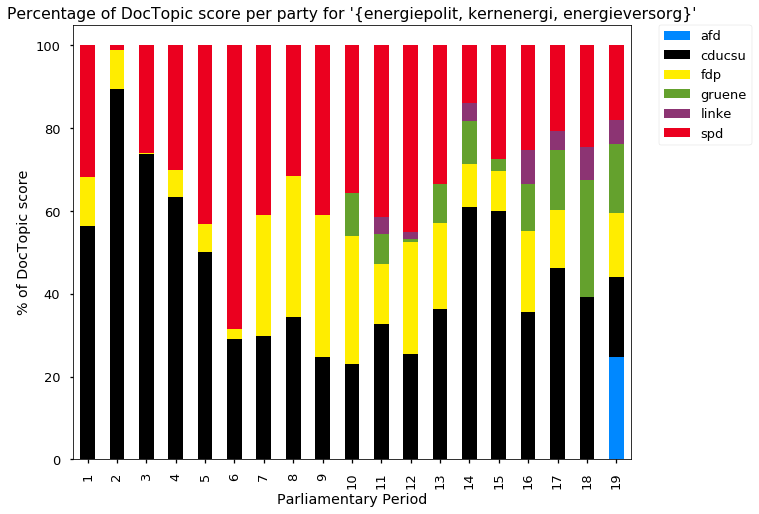

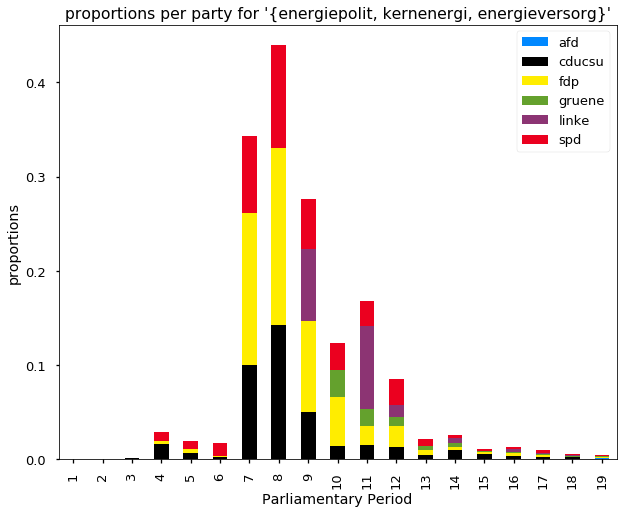

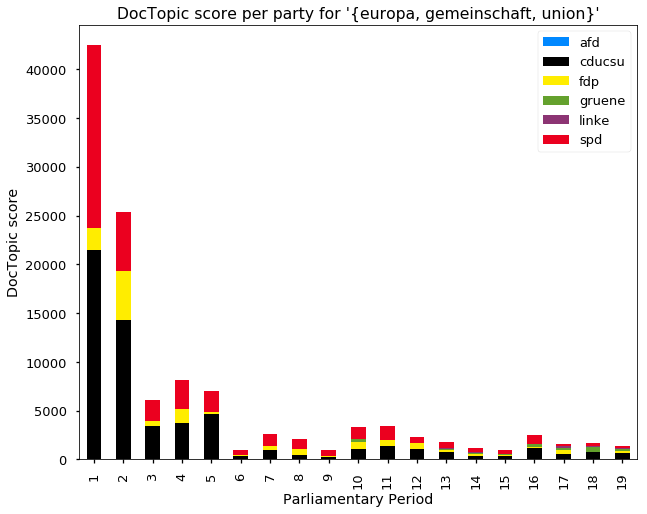

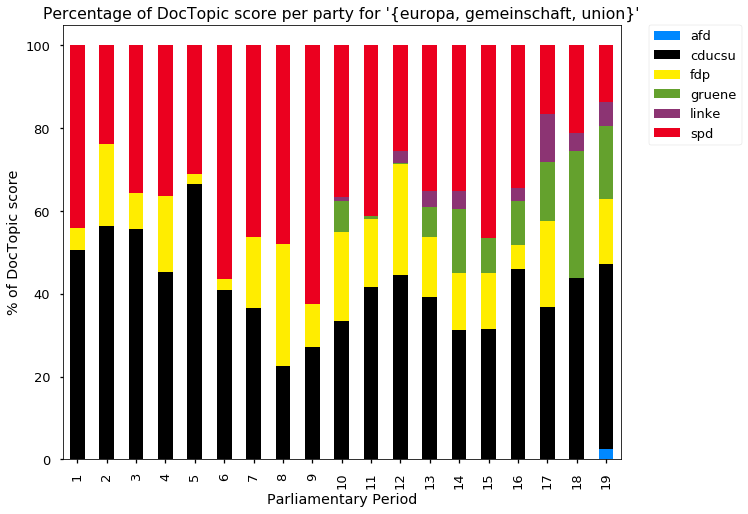

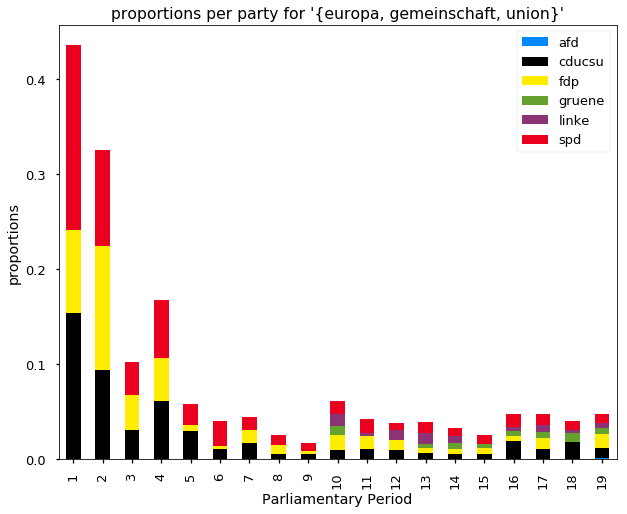

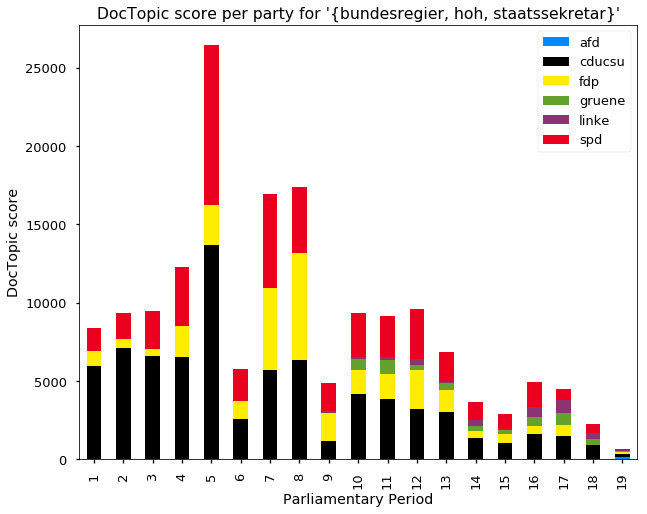

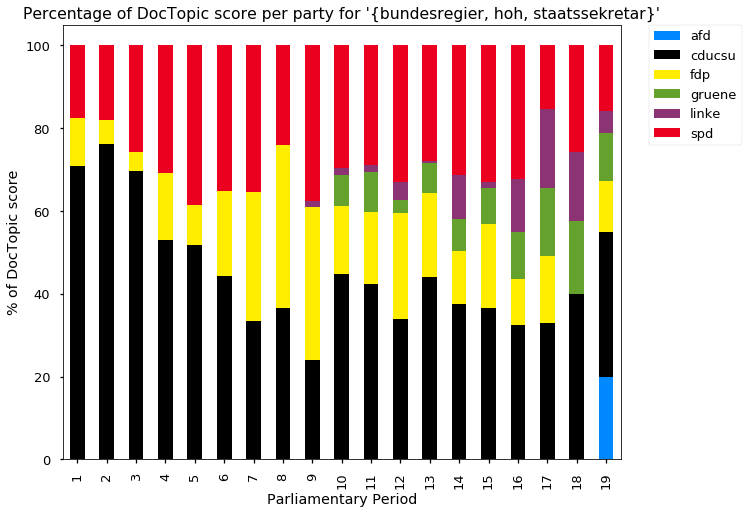

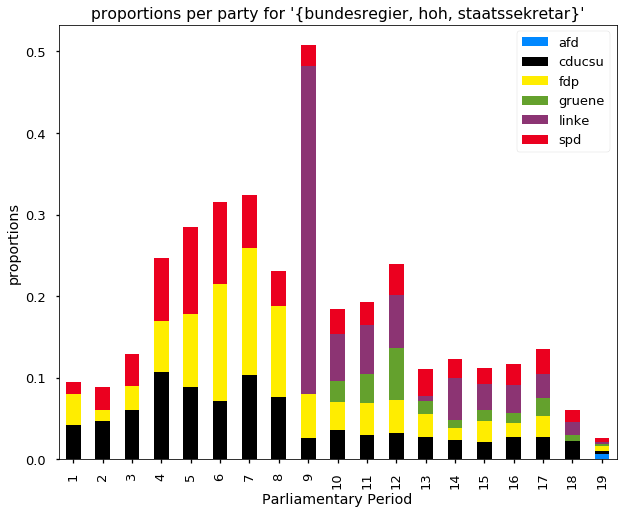

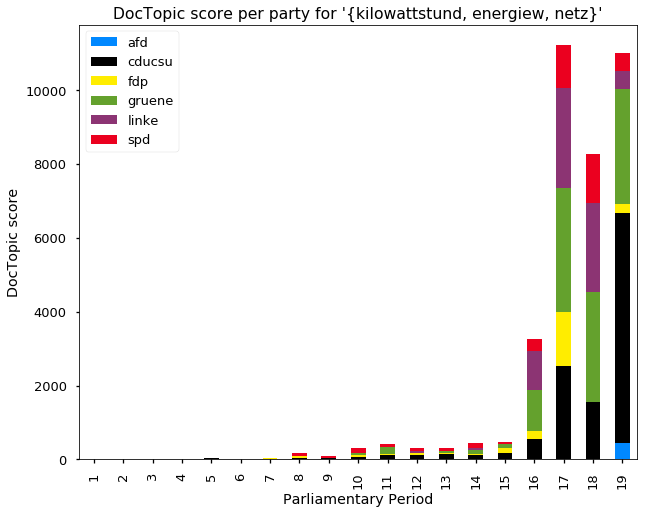

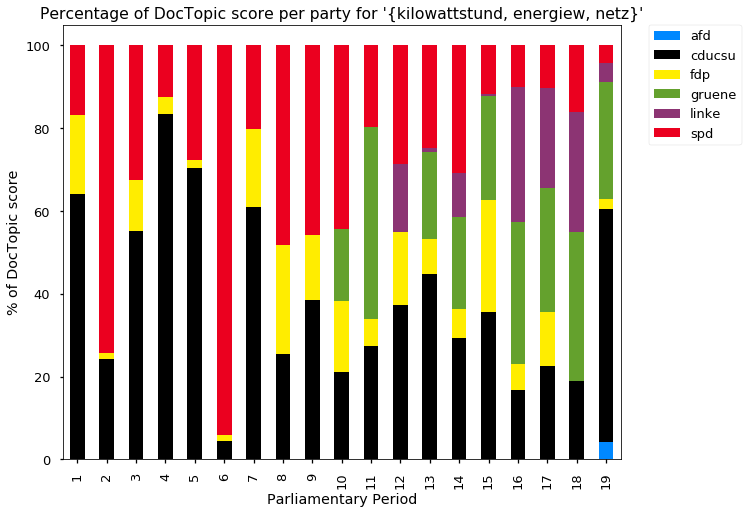

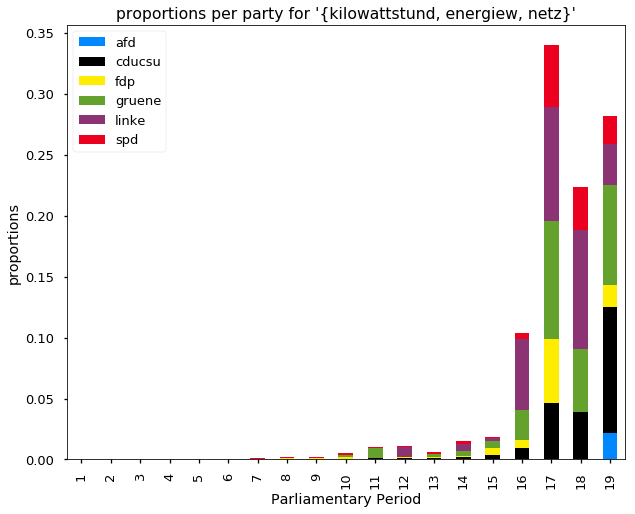

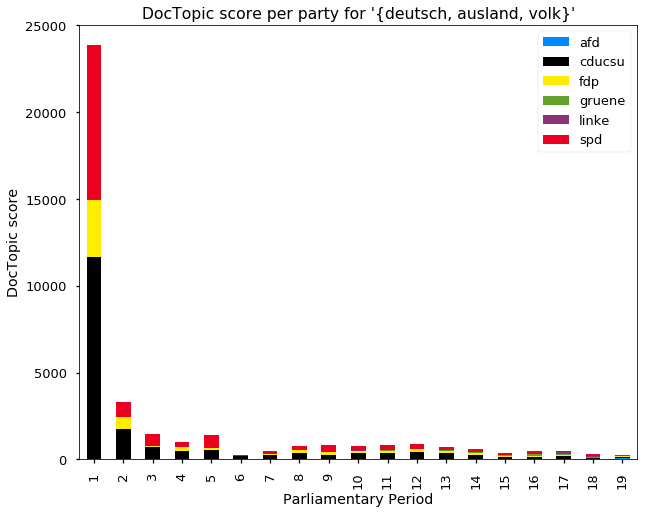

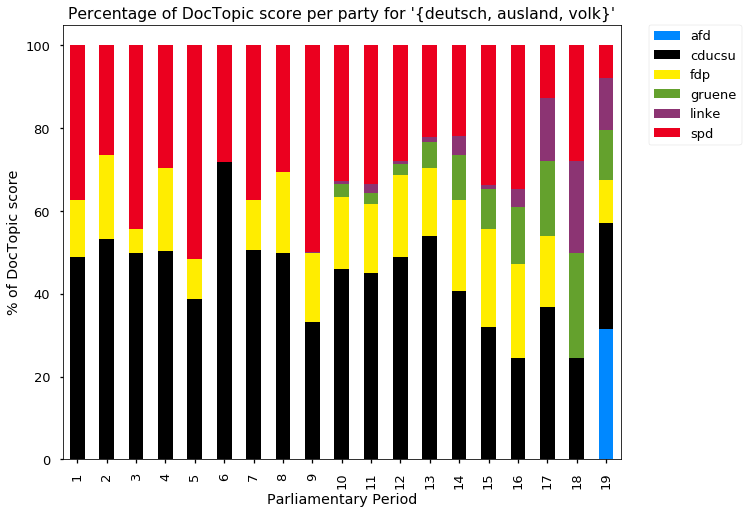

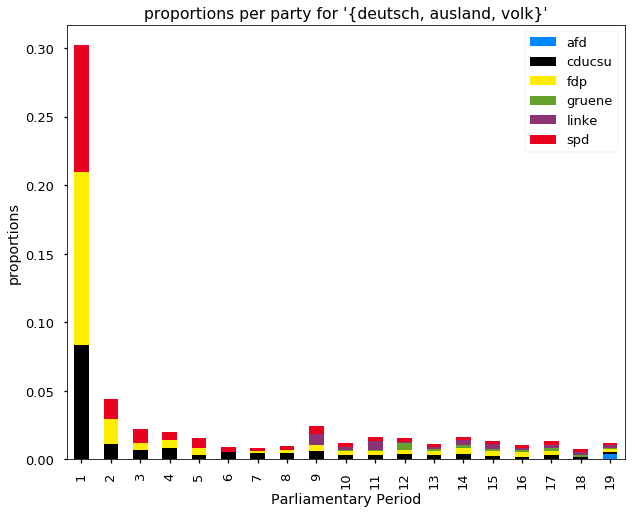

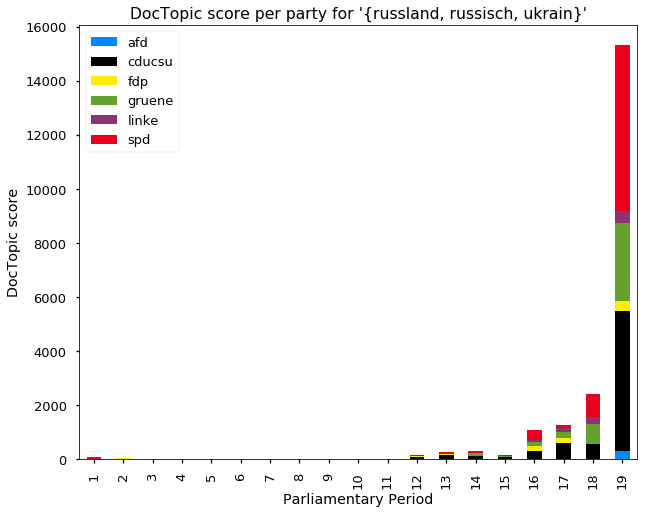

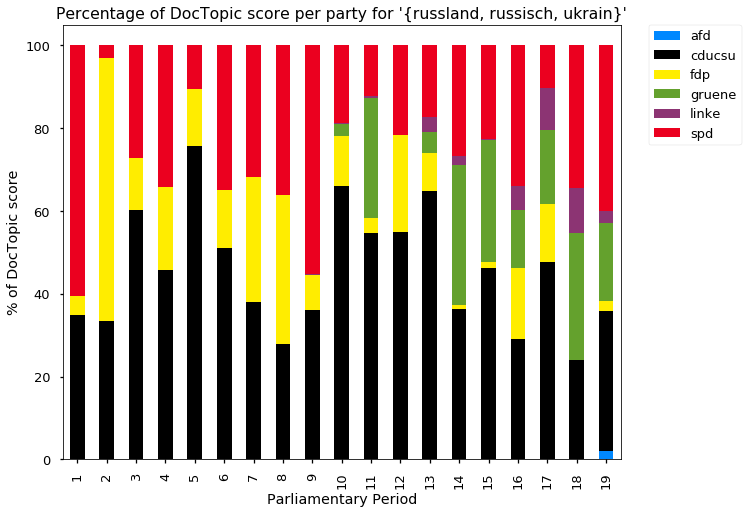

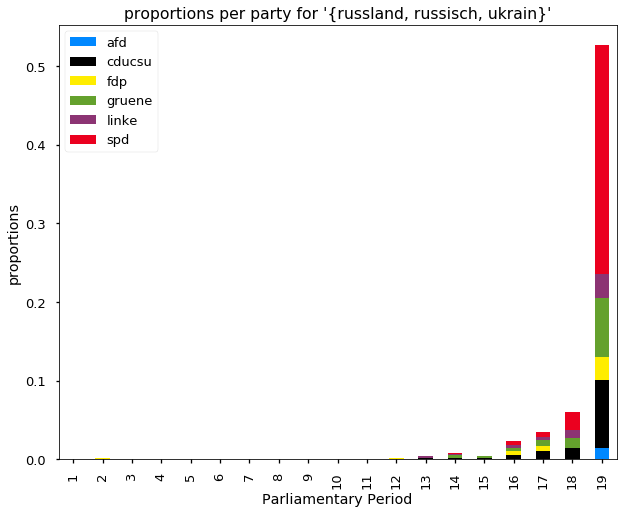

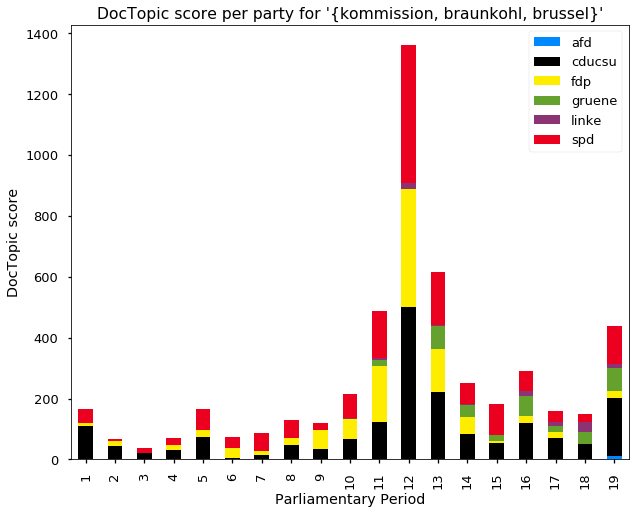

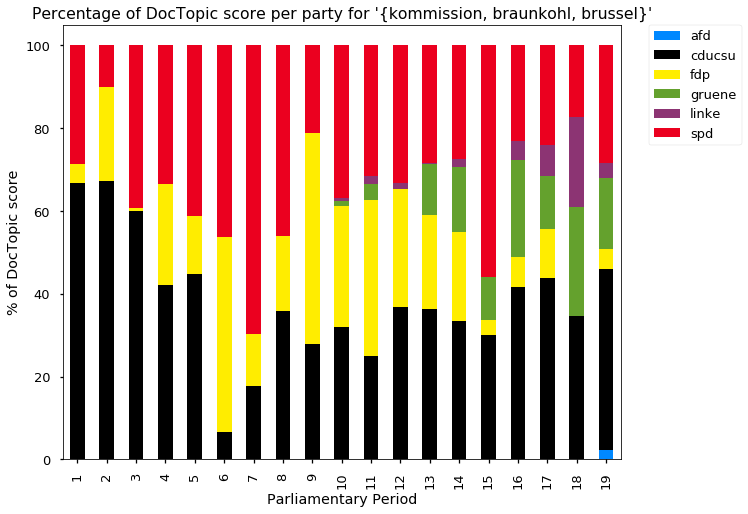

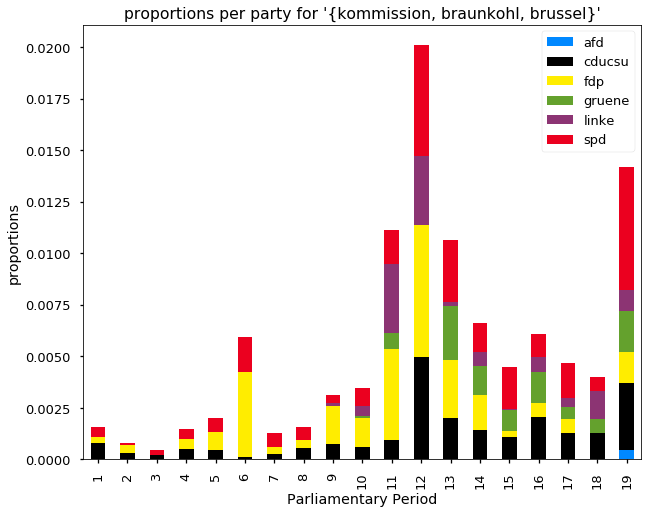

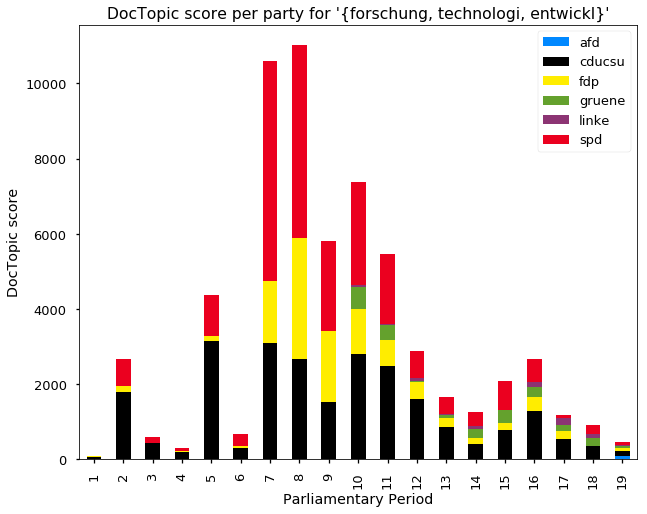

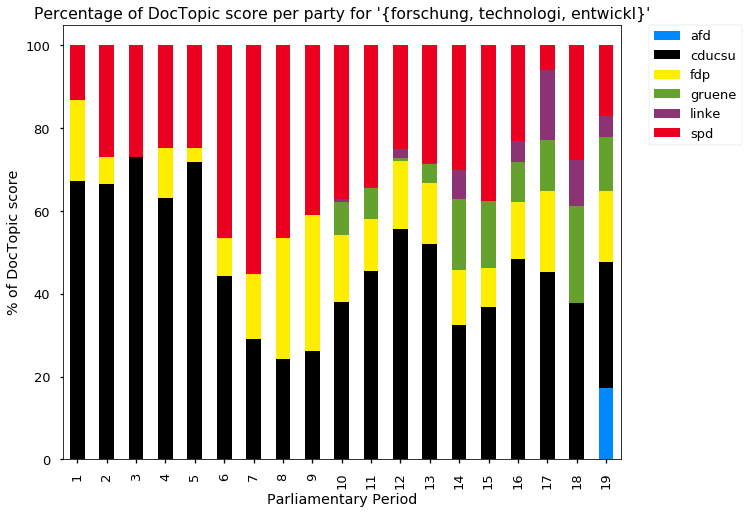

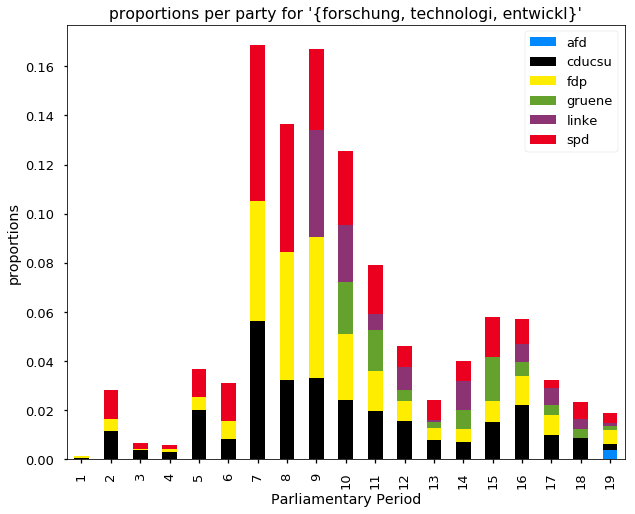

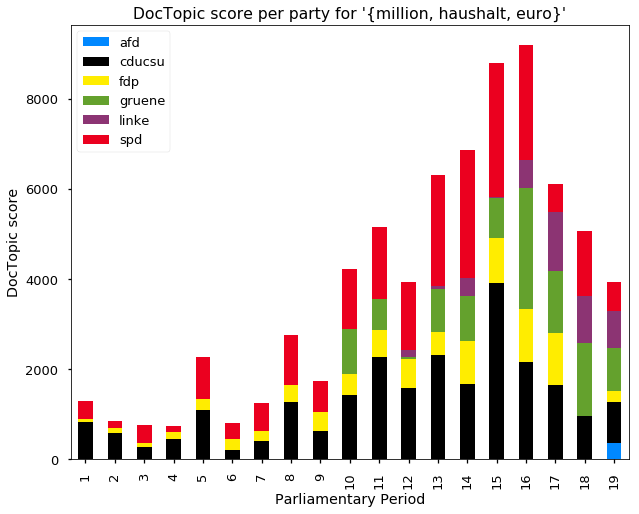

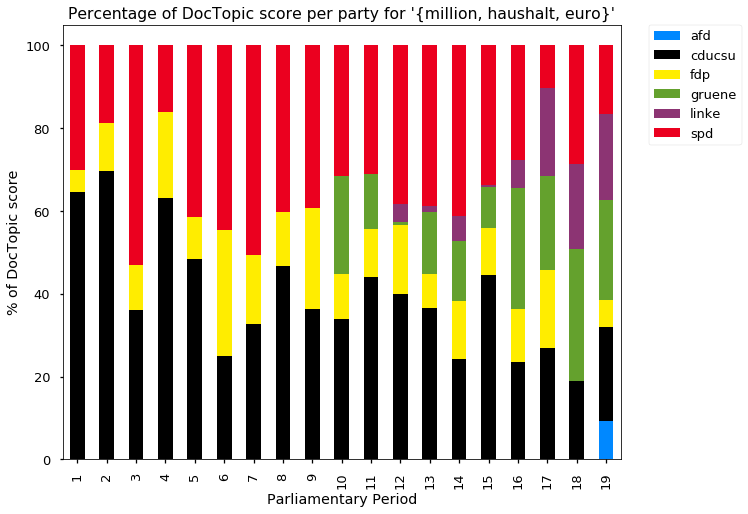

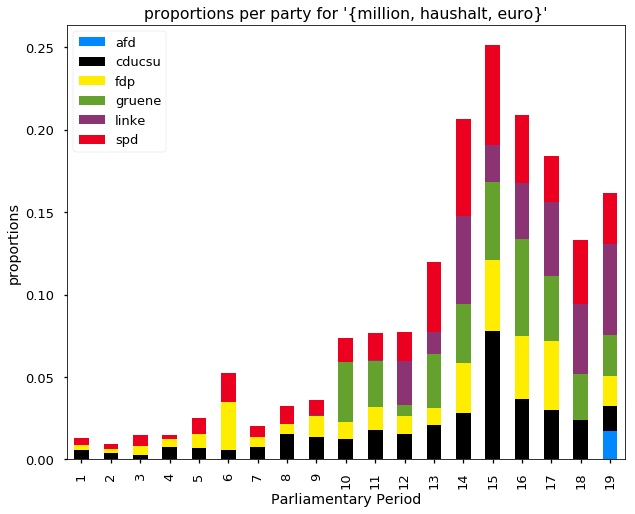

In [86]:
# for ISIE talk:
#topic_id = 167089 # climate policy
#topic_id = 167076 # economy and jobs

topics = Topic.objects.filter(run_id=run_id)

for topic in topics:
    df_scores, df_proportions = get_table_for_party_plots(topic.id)
    topic_label = topic.title
    stacked_bar_plot_party(df_scores, topic_label, filename=os.path.join(save_dir, 'party_scores_run_{}_topic_{}.png'.format(run_id, topic.id)))
    stacked_bar_plot_party(df_scores, topic_label, pct=True, filename=os.path.join(save_dir, 'party_scores_pct_run_{}_topic_{}.png'.format(run_id, topic.id)))
    stacked_bar_plot_party(df_proportions, topic_label, value_name='proportions', filename=os.path.join(save_dir, 'party_proportions_run_{}_topic_{}.png'.format(run_id, topic.id)))

    del df_scores, df_proportions

# compress folder to easily download it

In [87]:
%%bash
zip -r plots/topic_analysis_2111.zip plots/topic_analysis_2111/

updating: plots/topic_analysis_2111/ (stored 0%)
updating: plots/topic_analysis_2111/topic_term_scores_run_2111_topic_177254.png (deflated 10%)
updating: plots/topic_analysis_2111/topic_top_words_run_2111_topic_177268.png (deflated 20%)
updating: plots/topic_analysis_2111/party_proportions_run_2111_topic_177250.png (deflated 23%)
updating: plots/topic_analysis_2111/topic_top_words_run_2111_topic_177273.png (deflated 9%)
updating: plots/topic_analysis_2111/topic_term_scores_run_2111_topic_167079.png (deflated 10%)
updating: plots/topic_analysis_2111/party_proportions_run_2111_topic_177237.png (deflated 23%)
updating: plots/topic_analysis_2111/party_proportions_run_2111_topic_177241.png (deflated 24%)
updating: plots/topic_analysis_2111/party_proportions_run_2111_topic_177248.png (deflated 24%)
updating: plots/topic_analysis_2111/topic_top_words_run_2111_topic_177263.png (deflated 9%)
updating: plots/topic_analysis_2111/party_proportions_run_2111_topic_177249.png (deflated 26%)
updating: